# Percentage-phase reconstruction and analysis

This notebook focuses on **reconstructing FUCCI phase percentage trajectories**
from incomplete or noisy fluorescence signals. It is particularly useful when
recordings are low-frame-rate, partially missing, or where FUCCI intensities have
bleaching / dropout.

**You will learn to:**
- Load FUCCIphase output tables (phase % vs. time)
- Interpolate missing intervals or irregular sampling
- Reconstruct smooth phase-refined trajectories
- Compare raw vs reconstructed phase percentage traces
- Produce plots for publication or review reporting

**Use this notebook when**
- You want to correct temporal discontinuities in phase estimations  
- You need a clean, continuous phase percentage trajectory for modelling  
- You want to quantify how reconstruction changes biological interpretation  

**Inputs**

| File type           | Description                                    |
|---------------------|------------------------------------------------|
| `*_processed.csv`   | output of `fucciphase` CLI or other notebooks  |
| optional TIFF + XML | only required if re-deriving intensities       |

**Outputs**

Reconstructed phase + time tables, ready for downstream stats or visualisation.

In [21]:
import glob
import json
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from fucciphase import process_trackmate
from fucciphase.phase import (
    estimate_cell_cycle_percentage,
    estimate_percentage_by_subsequence_alignment,
)
from fucciphase.plot import plot_normalized_intensities
from fucciphase.sensor import FUCCISASensor
from fucciphase.utils import normalize_channels, postprocess_estimated_percentages

In [22]:
if not os.path.isdir("figures"):
    os.mkdir("figures")

## Read all TrackMate outputs

* Multiple videos were processed are saved as XML files
* The XML files should follow a template naming scheme so that it can be identified

In [29]:
template_file = "../reproducibility/inputs/*.xml"
track_files = glob.glob(template_file)
print(track_files)

['../reproducibility/inputs\\merged_linked.ome.xml', '../reproducibility/inputs\\merged_linked.ome_processed.xml', '../reproducibility/inputs\\merged_linked.ome_processed_processed.xml']


# General information

In [30]:
cyan_channel = "MEAN_INTENSITY_CH2"
magenta_channel = "MEAN_INTENSITY_CH1"
regex = r"Track_[0-9]+\.[a-z]+"
timestep = 0.25  # in hours
sensorfile = "../example_data/fuccisa_hacat.json"
reference_file = "../example_data/hacat_fucciphase_reference.csv"

In [31]:
reference_df = pd.read_csv(reference_file)
reference_df.rename(
    columns={"cyan": cyan_channel, "magenta": magenta_channel}, inplace=True
)

In [32]:
with open(sensorfile) as fp:
    sensor_properties = json.load(fp)

In [33]:
sensor = FUCCISASensor(**sensor_properties)

# Get all tracks with full cycle

In [34]:
# tracks followed by another branch
dfs_save_tracks = []
# tracks that are not followed by another branch
dfs_candidate_tracks = []
for track_file in track_files:
    print(track_file)
    df = process_trackmate(
        track_file,
        channels=[cyan_channel, magenta_channel],
        sensor=sensor,
        thresholds=[0.1, 0.1],
        generate_unique_tracks=True,
    )
    all_names = df["name"].unique()
    candidate_tracks = []
    track_ids = df["UNIQUE_TRACK_ID"].unique()
    for track_id in track_ids:
        track = df[df["UNIQUE_TRACK_ID"] == track_id]
        name = track["name"].iloc[0]
        last_frame = track["FRAME"].max()
        # is the track a subtrack
        match = re.match(regex, name)
        # is there a subtrack
        next_match = any(df["name"].str.match(name + "[a-z]+").unique())
        if match is not None and last_frame < df["FRAME"].max():
            print("Track ID: ", track_id)
            if next_match:
                dfs_save_tracks.append(track)
                title = f"Save track: {track_id}, {name}"
            else:
                if len(track) > 40:
                    dfs_candidate_tracks.append(track)
                    title = f"Candidate track: {track_id}, {name}"
                else:
                    continue

../reproducibility/inputs\merged_linked.ome.xml


C:\Users\SPL_ImageAnalysis-WS\Desktop\fucciphase\src\fucciphase\utils\track_postprocessing.py:352: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["UNIQUE_TRACK_ID"].update(new_track_ids)


Track ID:  11
Track ID:  20
Track ID:  17
Track ID:  14
../reproducibility/inputs\merged_linked.ome_processed.xml


C:\Users\SPL_ImageAnalysis-WS\Desktop\fucciphase\src\fucciphase\utils\track_postprocessing.py:352: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["UNIQUE_TRACK_ID"].update(new_track_ids)


Track ID:  11.0
Track ID:  20.0
Track ID:  17.0
Track ID:  14.0
../reproducibility/inputs\merged_linked.ome_processed_processed.xml


C:\Users\SPL_ImageAnalysis-WS\Desktop\fucciphase\src\fucciphase\utils\track_postprocessing.py:352: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["UNIQUE_TRACK_ID"].update(new_track_ids)


Track ID:  11.0
Track ID:  20.0
Track ID:  17.0
Track ID:  14.0


Use all tracks

In [35]:
dfs_save_tracks.extend(dfs_candidate_tracks)

## Process the DataFrame

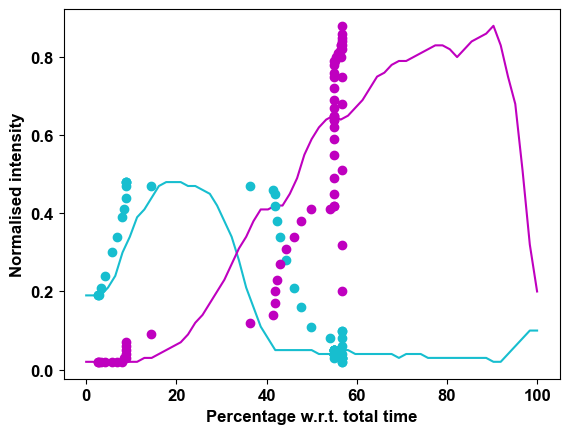

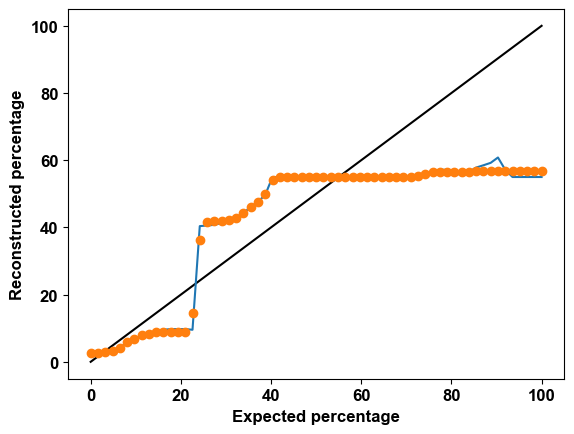

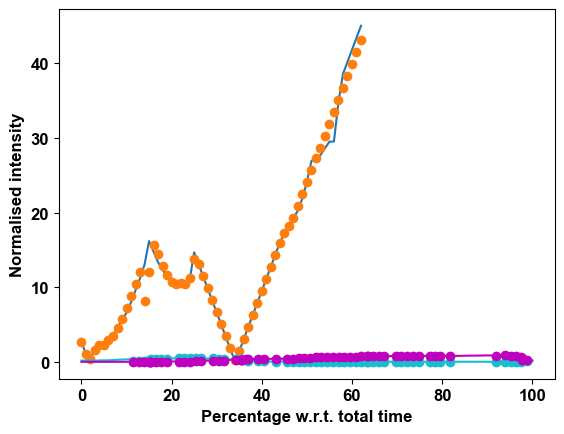

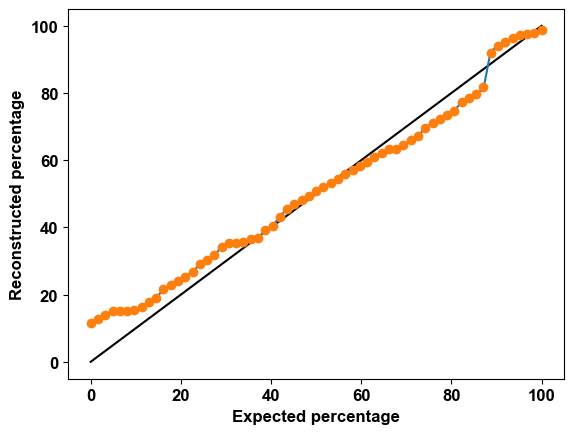

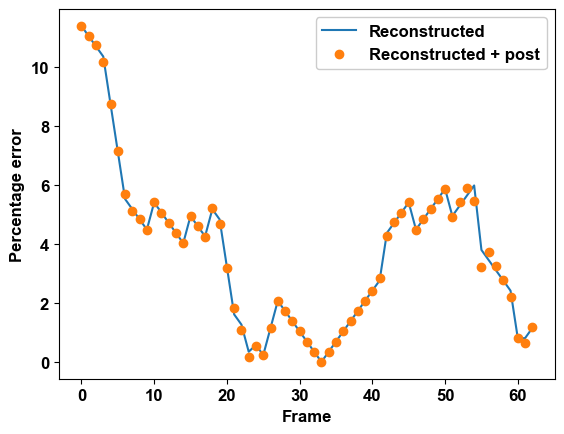

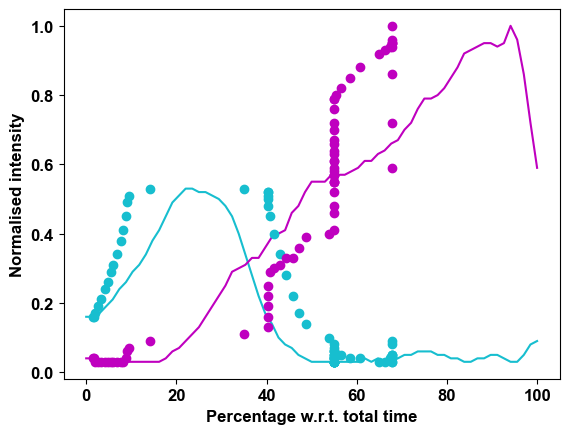

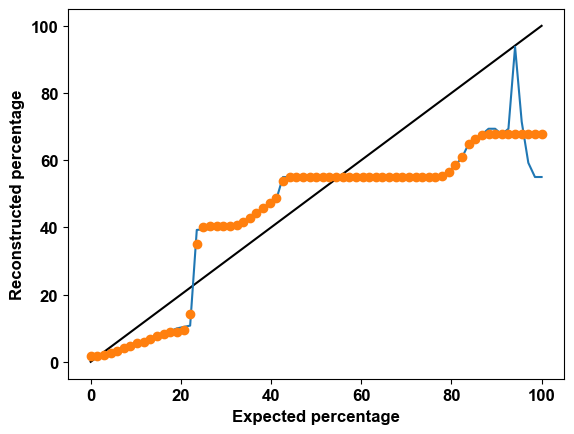

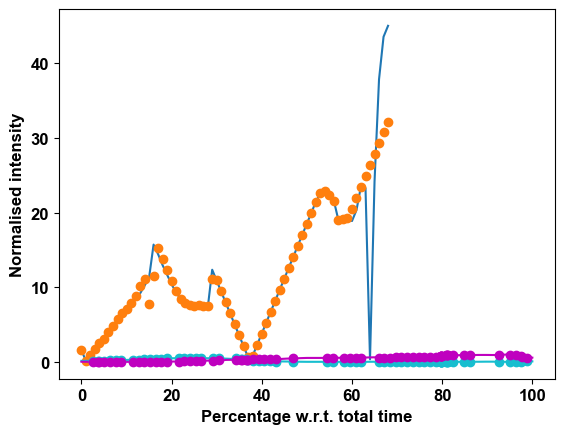

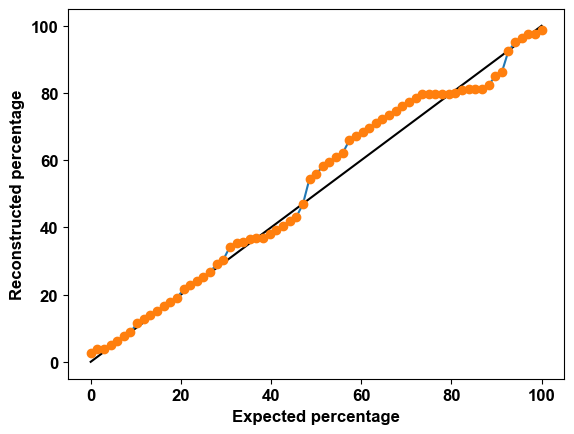

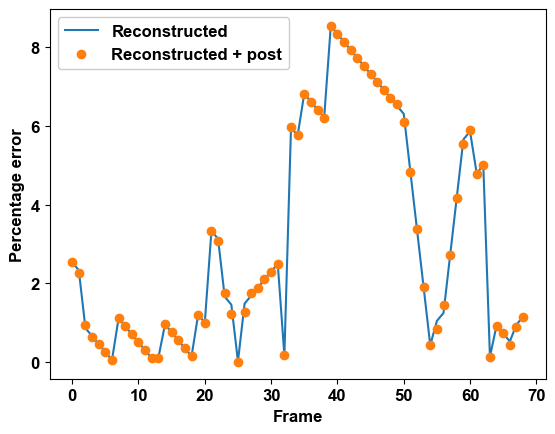

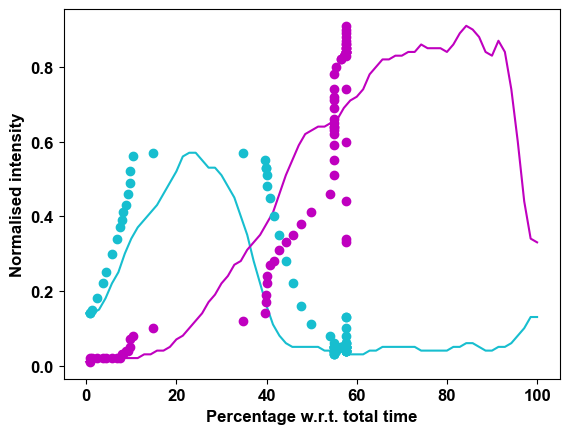

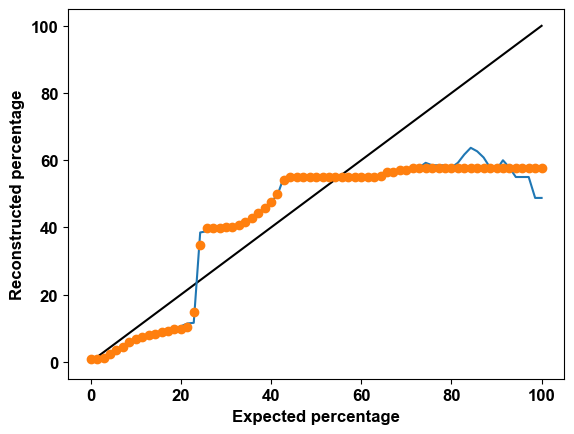

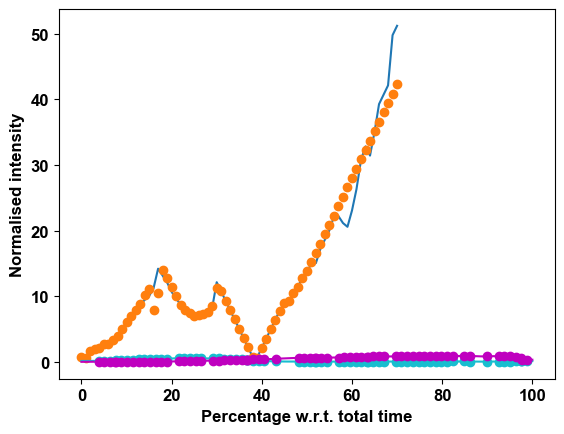

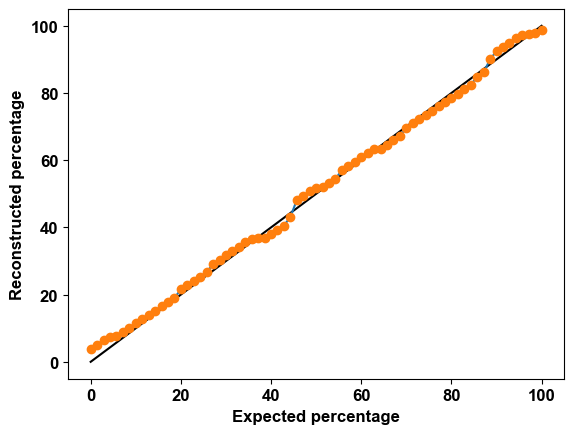

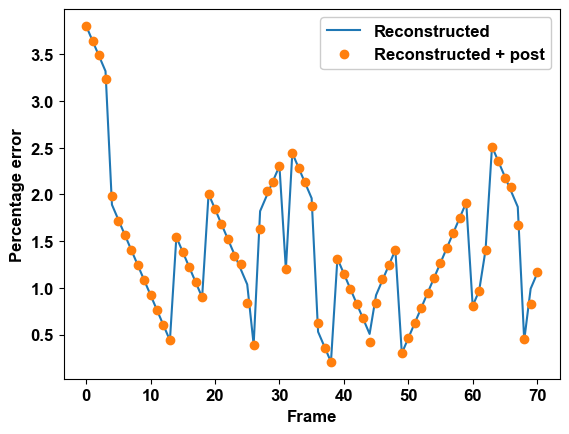

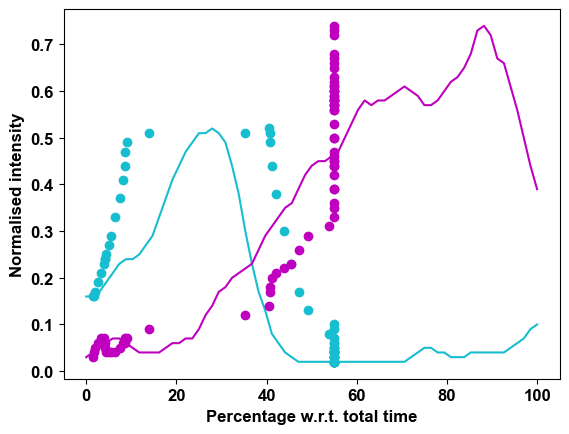

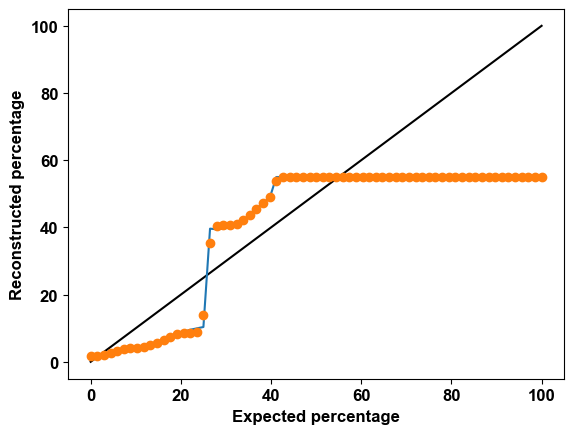

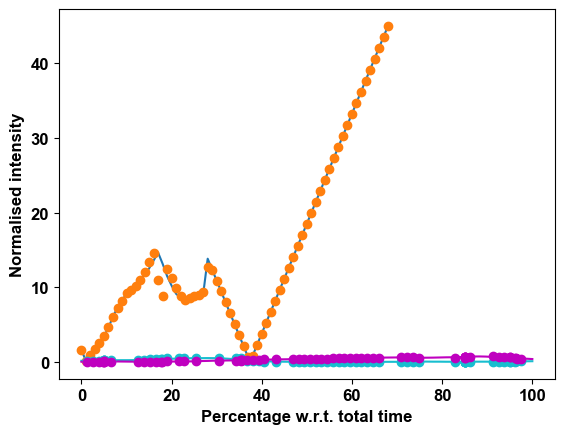

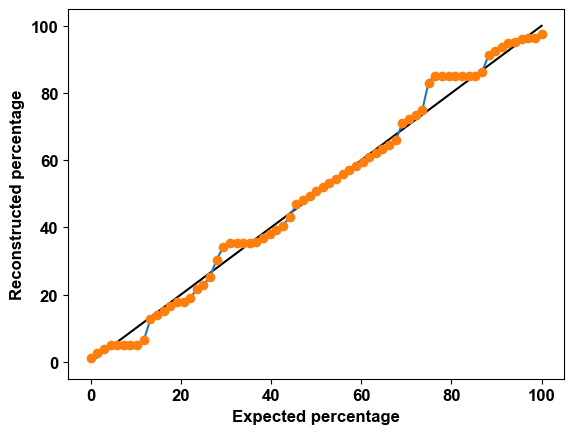

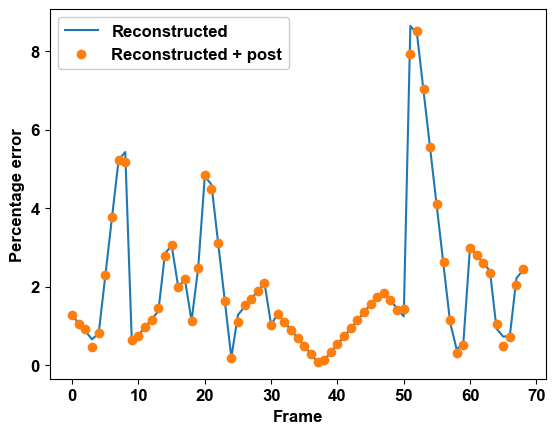

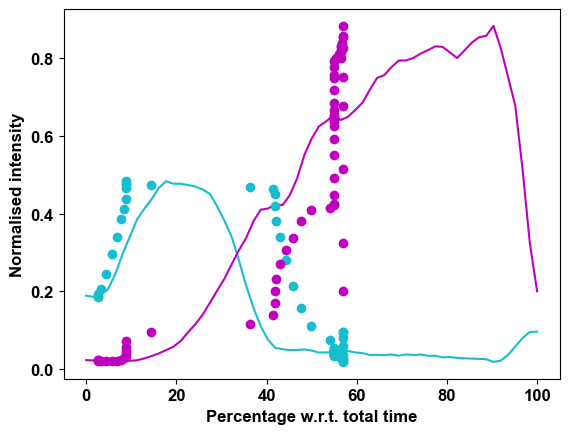

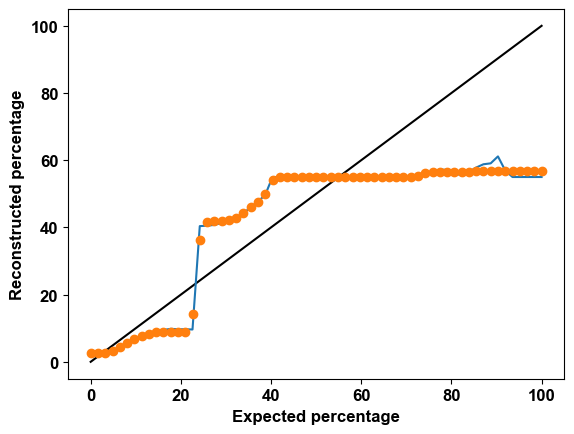

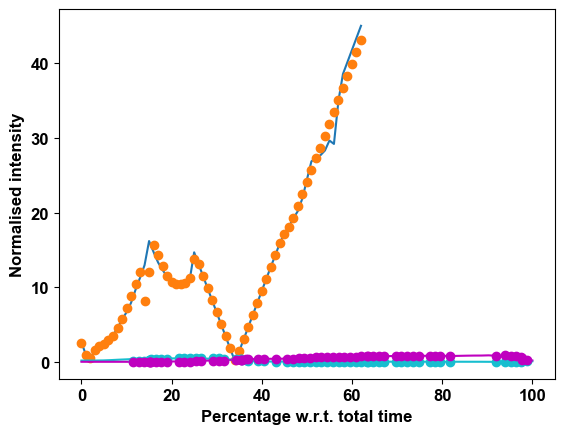

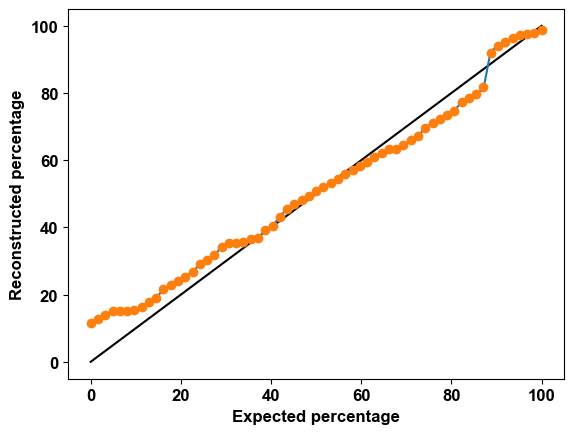

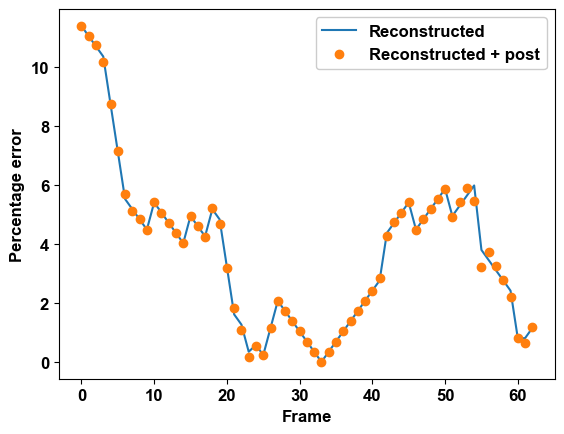

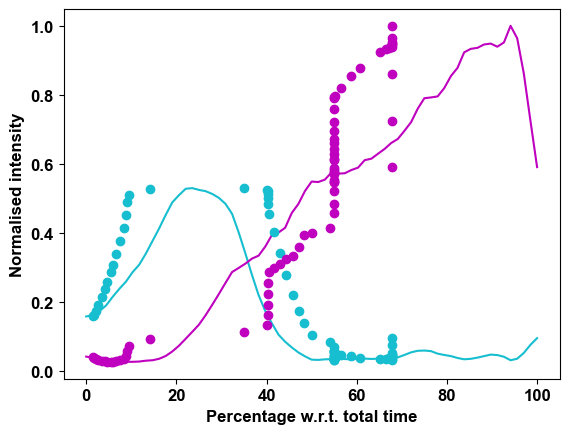

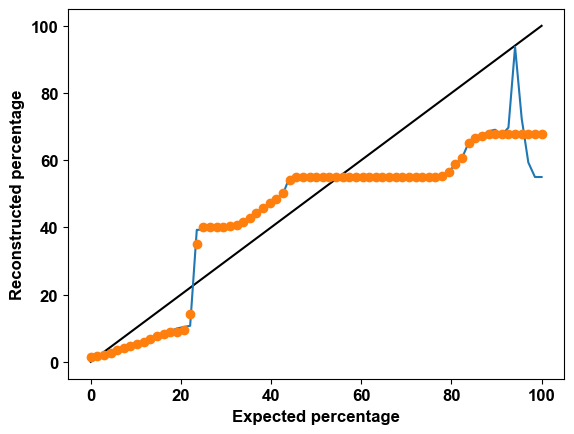

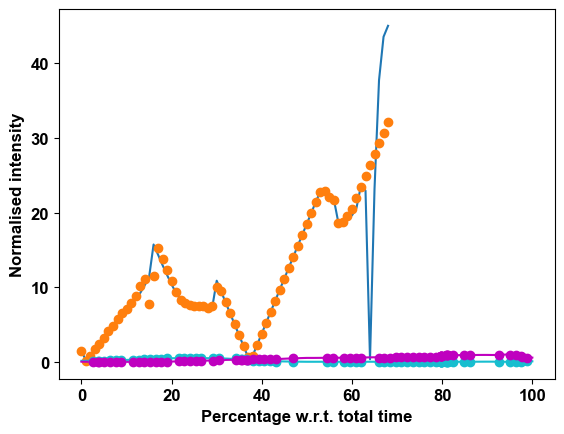

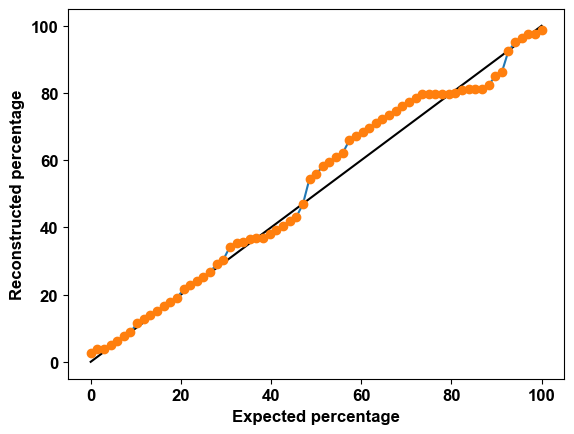

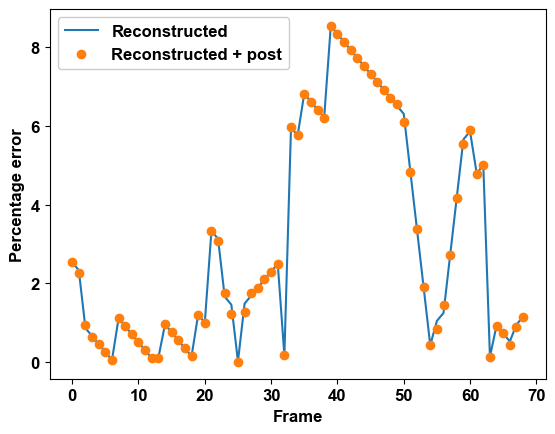

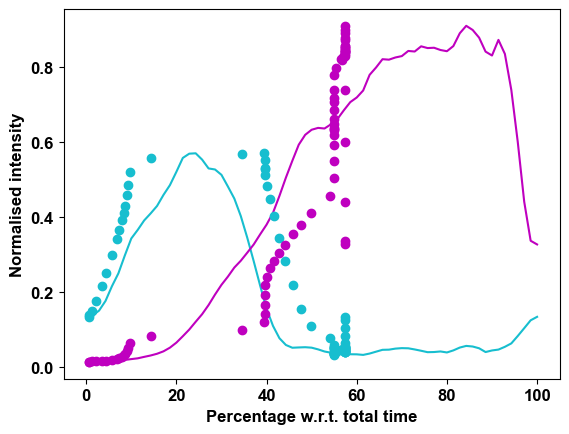

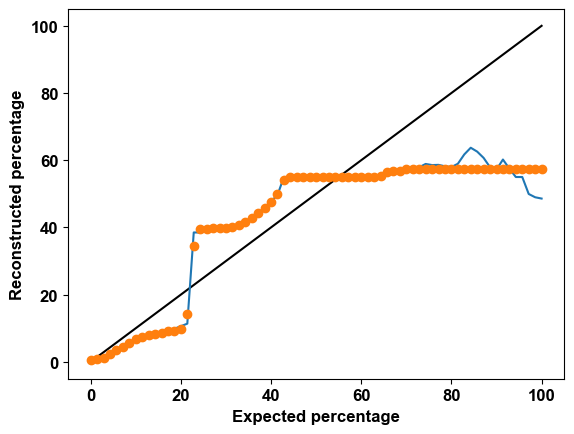

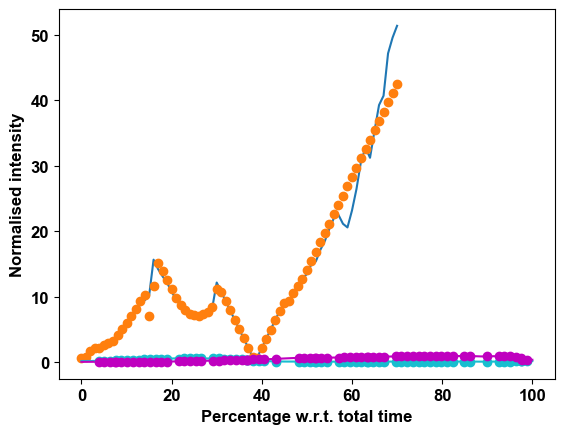

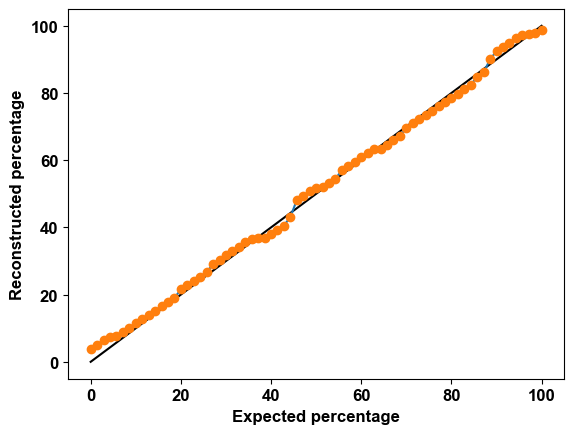

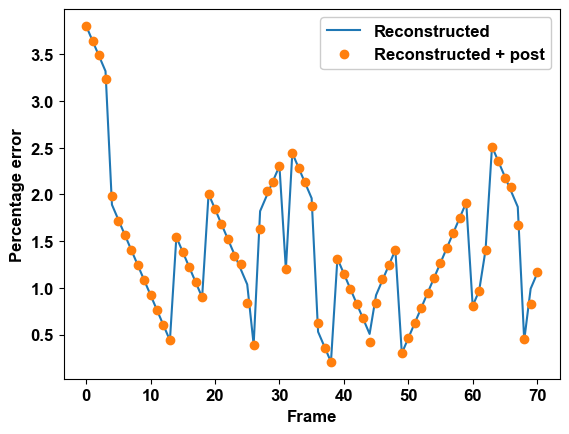

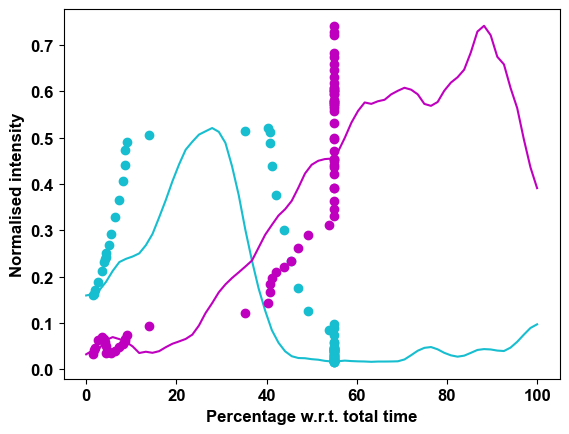

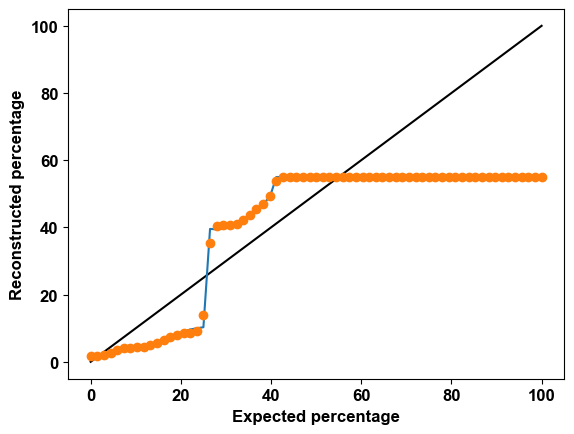

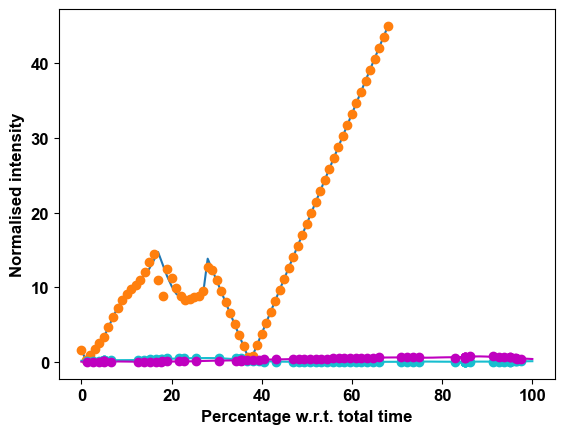

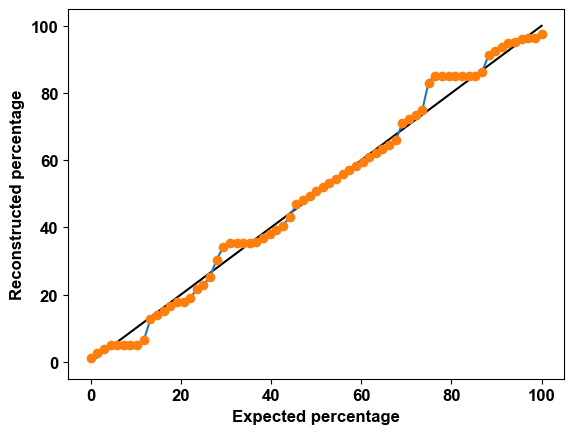

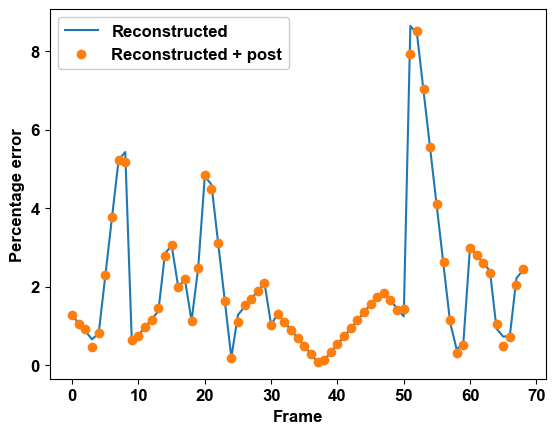

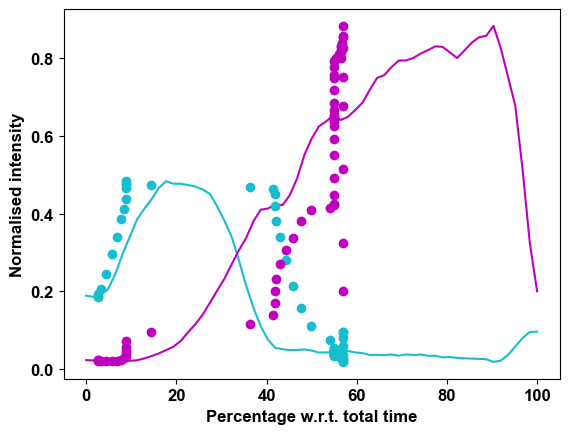

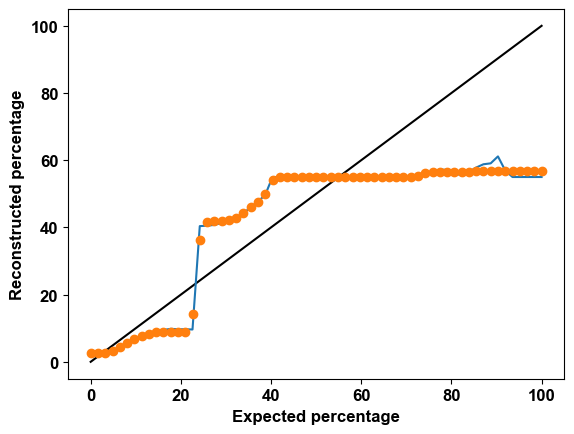

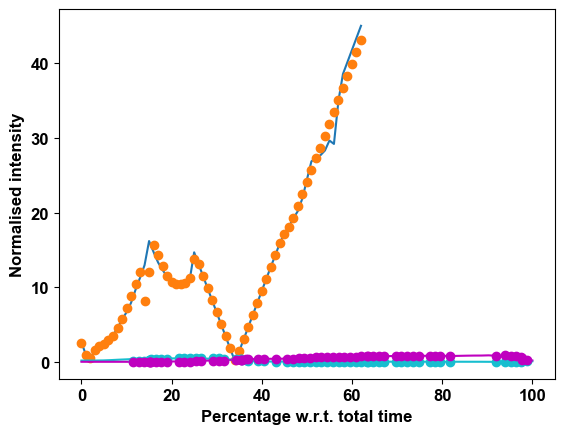

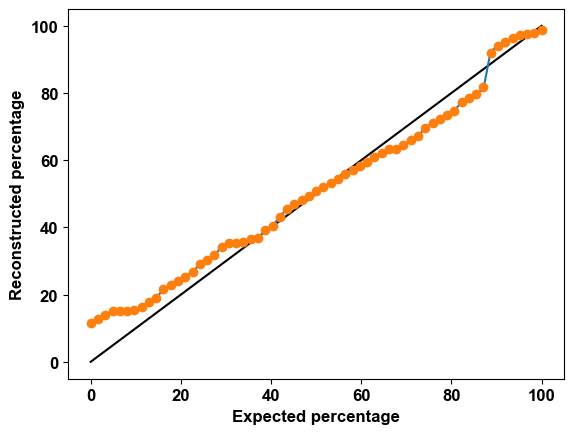

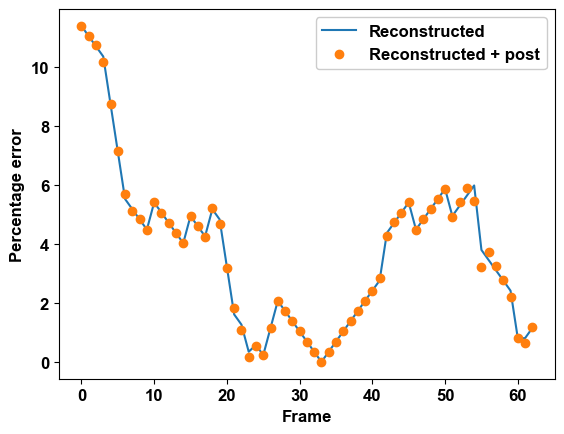

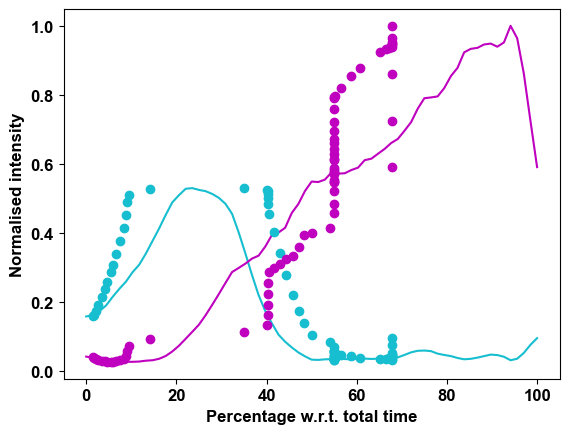

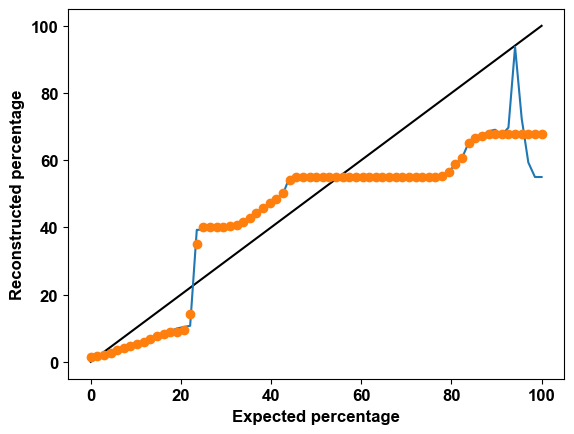

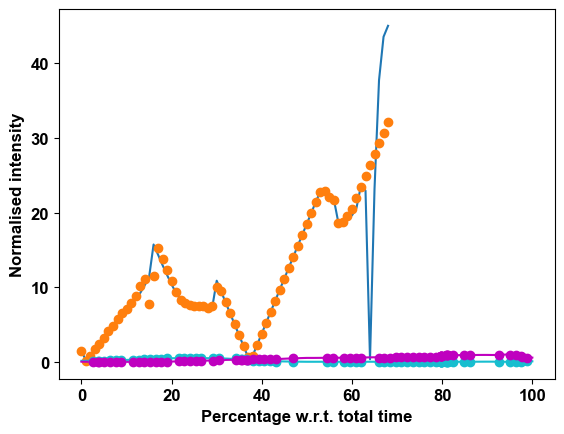

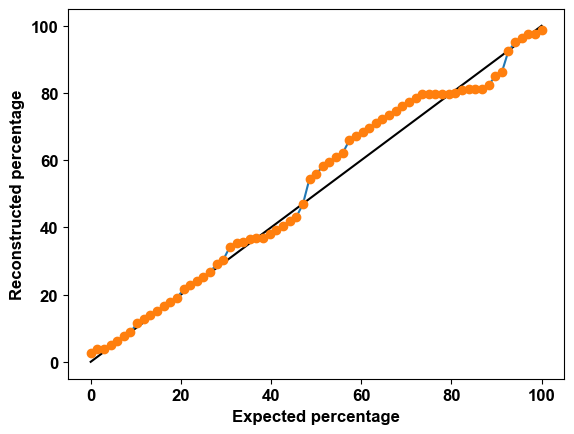

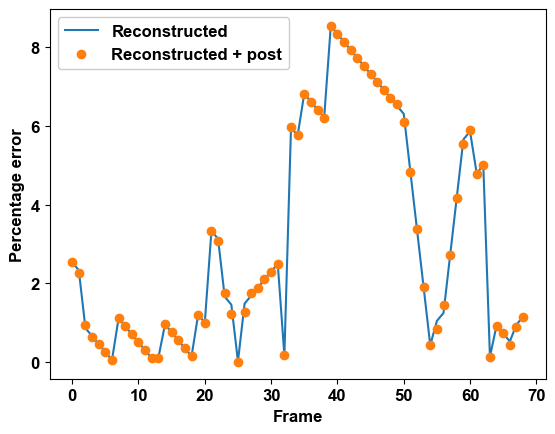

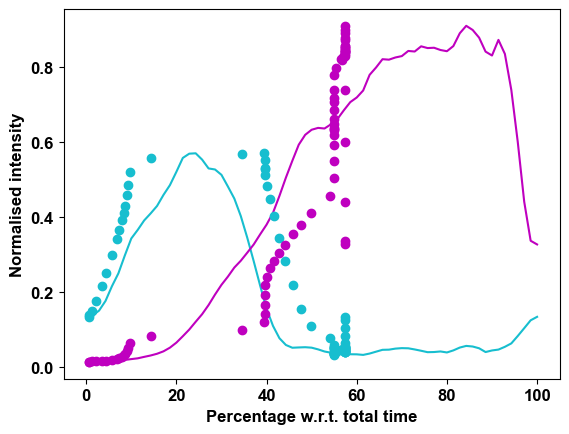

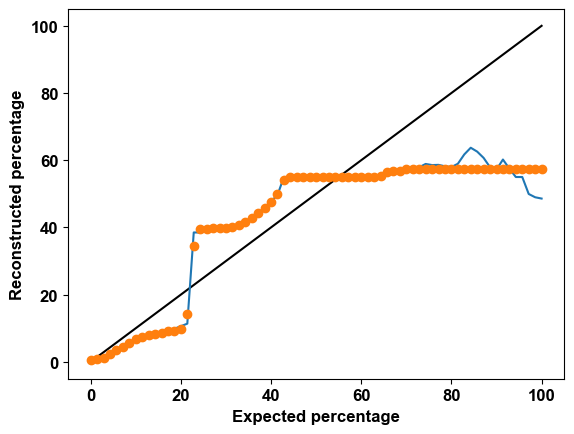

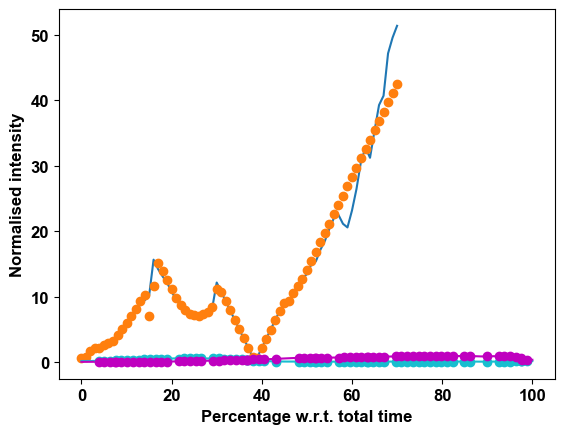

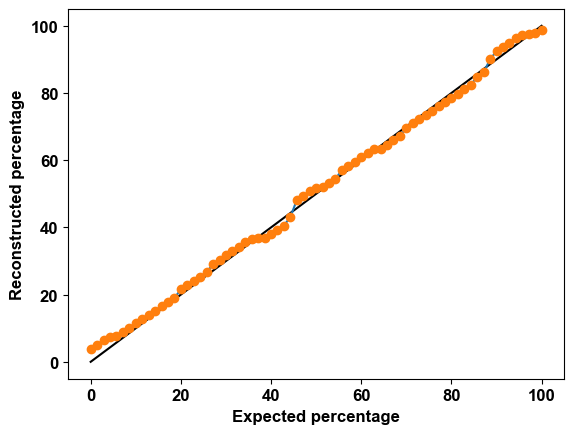

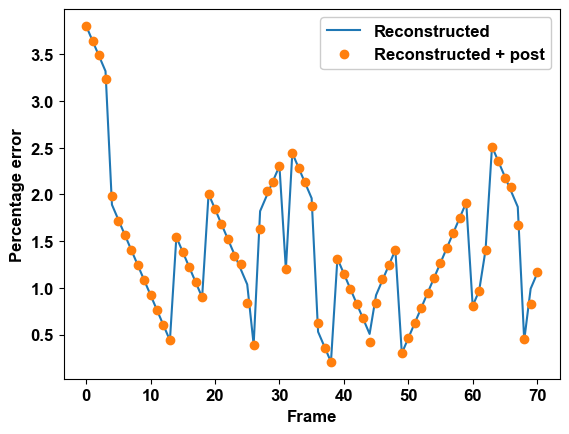

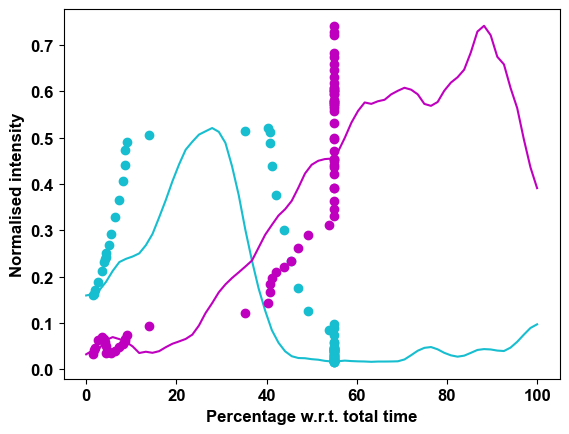

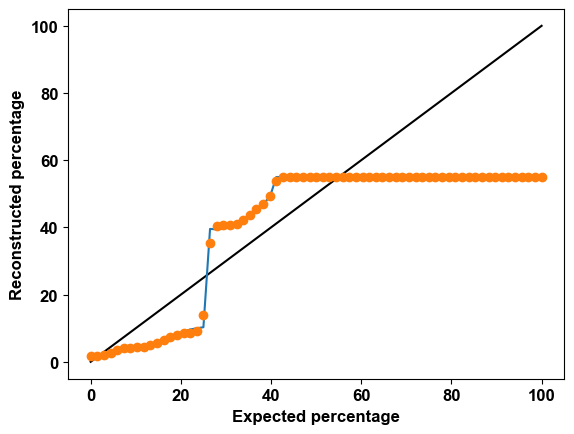

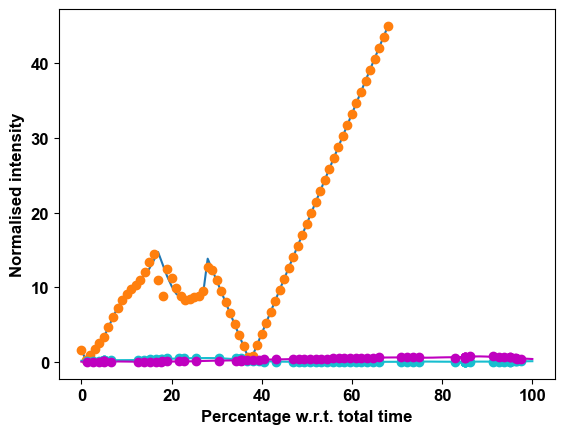

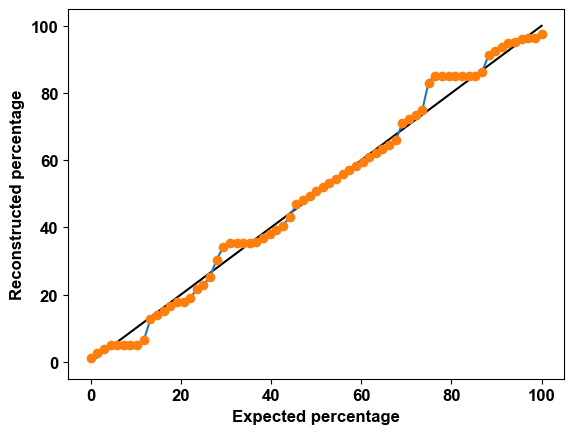

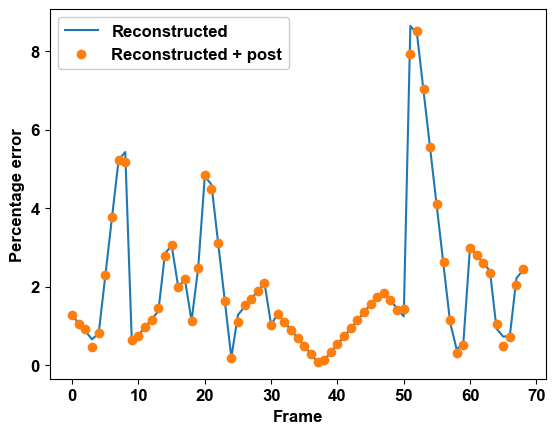

In [36]:
for idx, df in enumerate(dfs_save_tracks):
    # insert ground truth
    df["percentage"] = (
        100.0
        * (df["FRAME"] - df["FRAME"].min())
        / (df["FRAME"].max() - df["FRAME"].min())
    )
    postprocess_estimated_percentages(
        df, percentage_column="CELL_CYCLE_PERC", track_id_name="UNIQUE_TRACK_ID"
    )
    estimate_percentage_by_subsequence_alignment(
        df,
        dt=0.25,
        channels=[cyan_channel, magenta_channel],
        reference_data=reference_df,
        track_id_name="UNIQUE_TRACK_ID",
    )
    postprocess_estimated_percentages(
        df, percentage_column="CELL_CYCLE_PERC_DTW", track_id_name="UNIQUE_TRACK_ID"
    )

    plot_normalized_intensities(
        df,
        cyan_channel,
        magenta_channel,
        "tab:cyan",
        "m",
        time_column="percentage",
        time_label="Percentage w.r.t. total time",
    )
    plot_normalized_intensities(
        df,
        cyan_channel,
        magenta_channel,
        "tab:cyan",
        "m",
        time_column="CELL_CYCLE_PERC_POST",
        time_label="Percentage w.r.t. total time",
        marker="o",
        linestyle="",
    )
    plt.savefig(f"figures/global_normalization_static_intensities_{idx}.pdf")
    plt.show()

    plt.plot(df["percentage"], df["percentage"], color="black")
    plt.plot(df["percentage"], df["CELL_CYCLE_PERC"])
    plt.plot(df["percentage"], df["CELL_CYCLE_PERC_POST"], "o")
    plt.xlabel("Expected percentage")
    plt.ylabel("Reconstructed percentage")
    plt.savefig(f"figures/global_normalization_static_percentage_{idx}.pdf")
    plt.show()

    plt.plot(
        df["FRAME"] - df["FRAME"].min(),
        np.abs(df["percentage"] - df["CELL_CYCLE_PERC"]),
        label="Reconstructed",
    )
    plt.plot(
        df["FRAME"] - df["FRAME"].min(),
        np.abs(df["percentage"] - df["CELL_CYCLE_PERC_POST"]),
        "o",
        label="Reconstructed + post",
    )
    plt.ylabel("Percentage error")
    plt.xlabel("Frame")
    plt.savefig(f"figures/global_normalization_static_error_{idx}.pdf")

    plot_normalized_intensities(
        df,
        cyan_channel,
        magenta_channel,
        "tab:cyan",
        "m",
        time_column="percentage",
        time_label="Percentage w.r.t. total time",
    )
    plot_normalized_intensities(
        df,
        cyan_channel,
        magenta_channel,
        "tab:cyan",
        "m",
        time_column="CELL_CYCLE_PERC_DTW_POST",
        time_label="Percentage w.r.t. total time",
        marker="o",
        linestyle="",
    )
    plt.savefig(f"figures/global_normalization_dynamic_intensities_{idx}.pdf")

    plt.show()

    plt.plot(df["percentage"], df["percentage"], color="black")
    plt.plot(df["percentage"], df["CELL_CYCLE_PERC_DTW"])
    plt.plot(df["percentage"], df["CELL_CYCLE_PERC_DTW_POST"], "o")
    plt.xlabel("Expected percentage")
    plt.ylabel("Reconstructed percentage")
    plt.savefig(f"figures/global_normalization_dynamic_percentages_{idx}.pdf")
    plt.show()

    plt.plot(
        df["FRAME"] - df["FRAME"].min(),
        np.abs(df["percentage"] - df["CELL_CYCLE_PERC_DTW"]),
        label="Reconstructed",
    )
    plt.plot(
        df["FRAME"] - df["FRAME"].min(),
        np.abs(df["percentage"] - df["CELL_CYCLE_PERC_DTW_POST"]),
        "o",
        label="Reconstructed + post",
    )
    plt.legend(framealpha=1.0)
    plt.ylabel("Percentage error")
    plt.xlabel("Frame")
    plt.savefig(f"figures/global_normalization_dynamic_error_{idx}.pdf")
    plt.show()

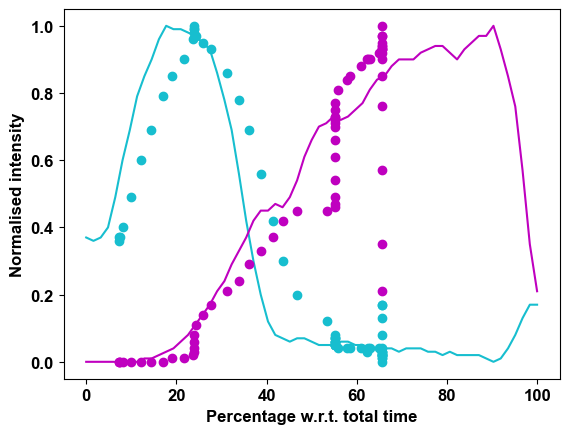

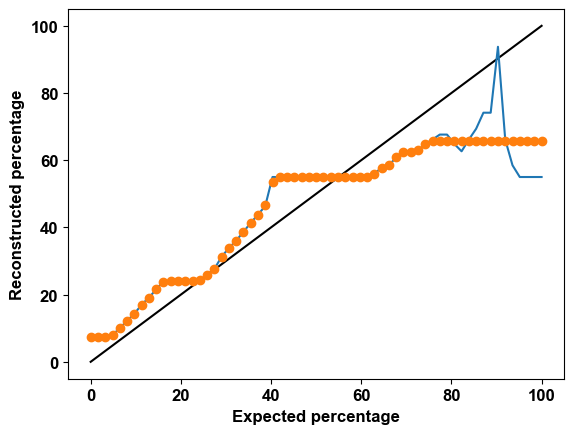

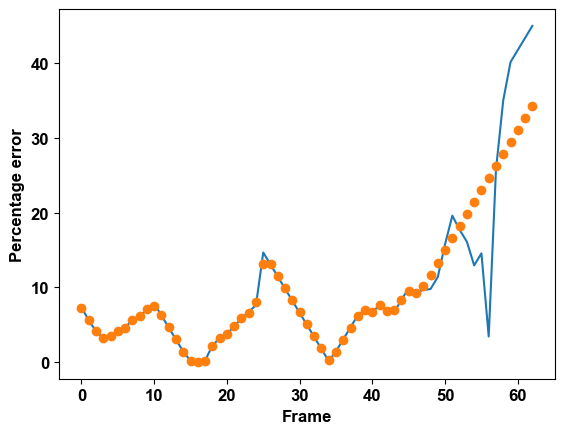

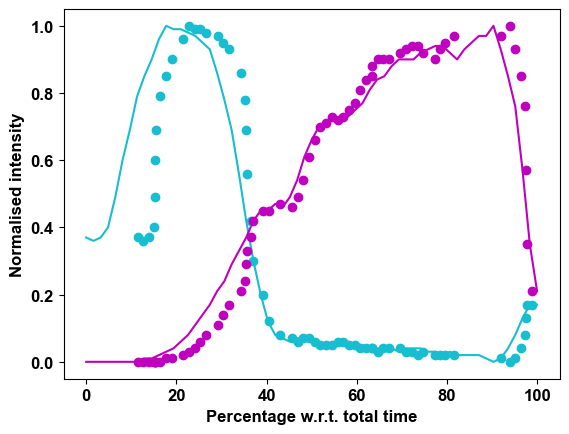

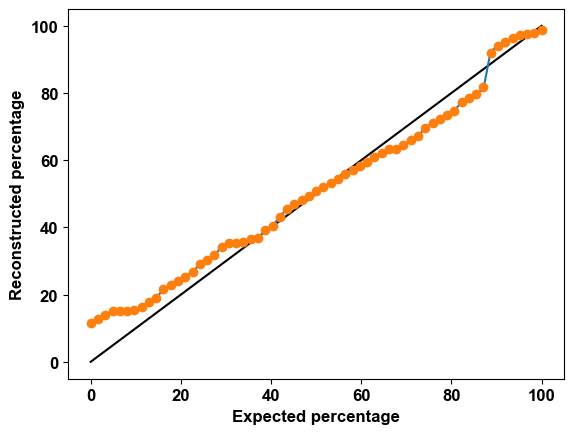

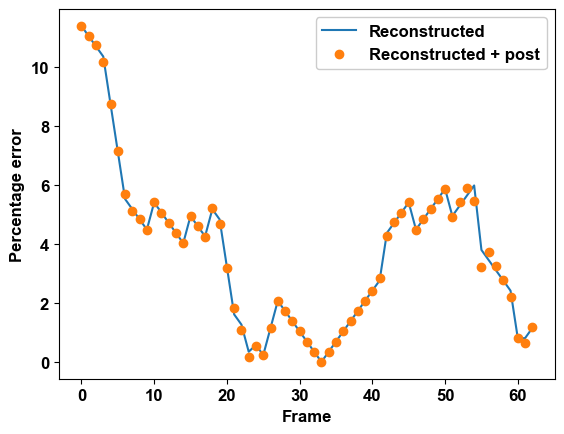

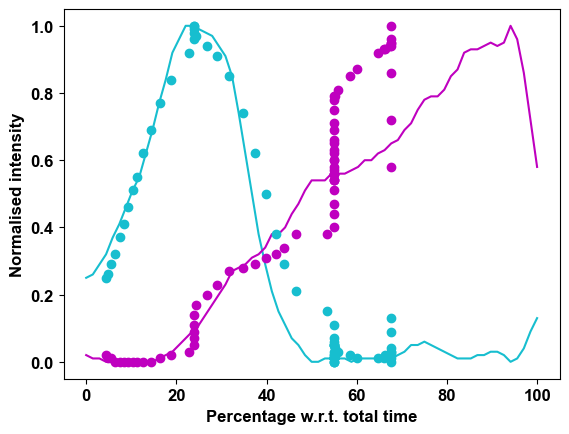

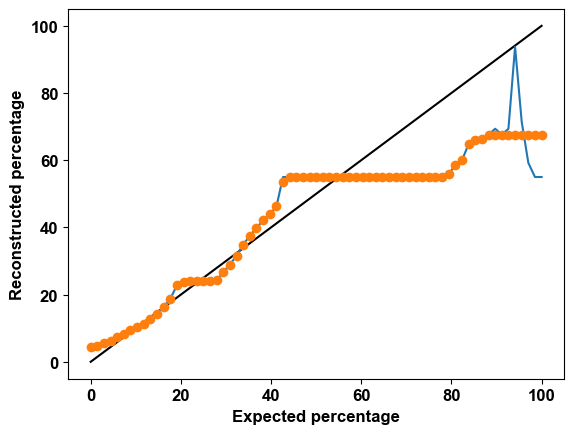

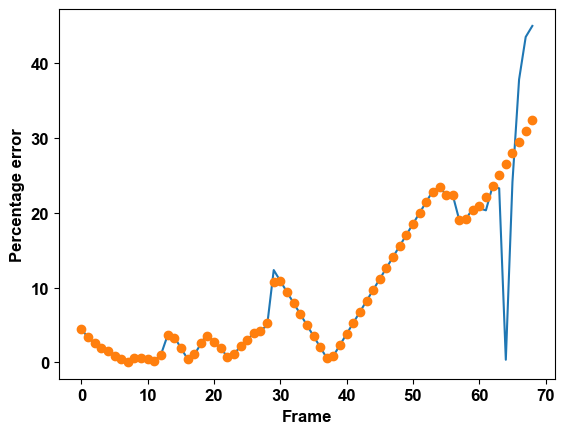

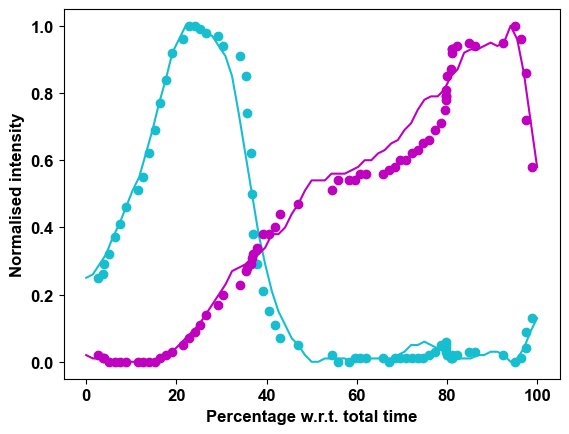

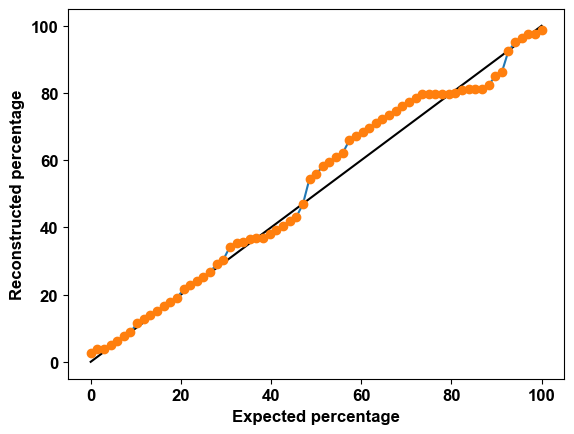

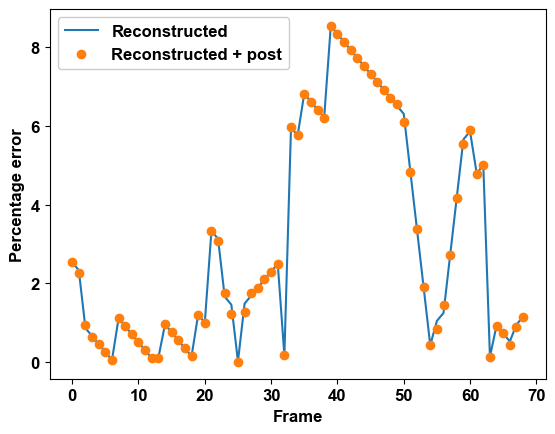

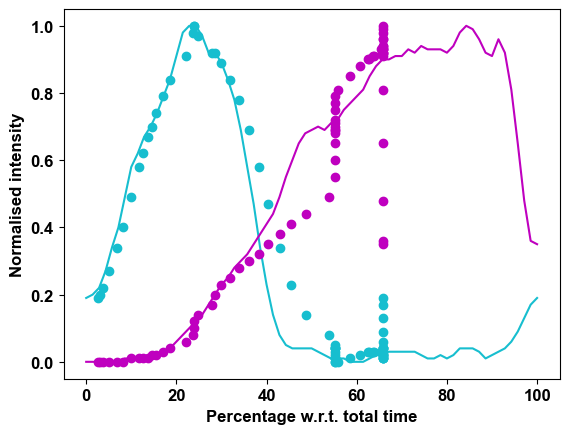

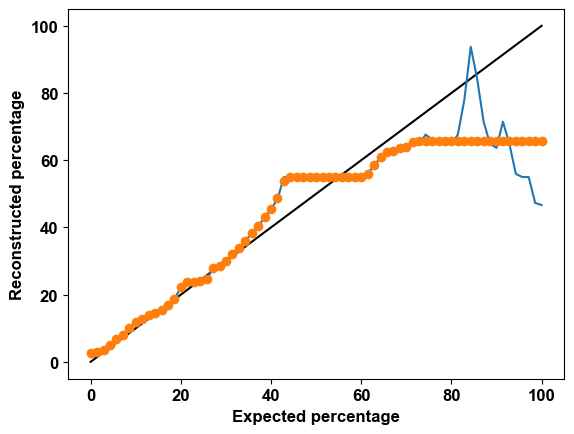

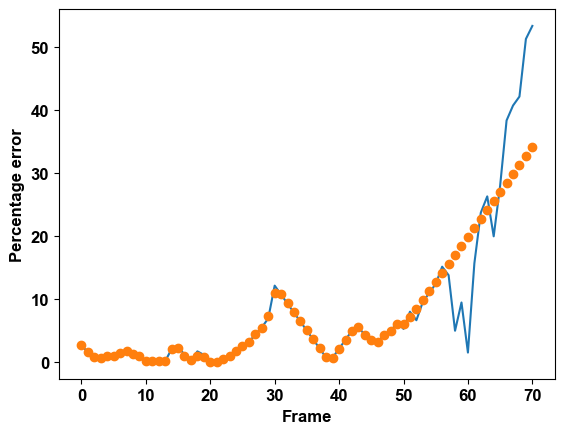

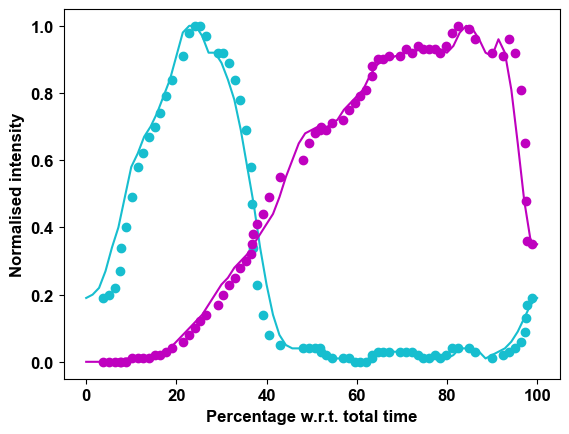

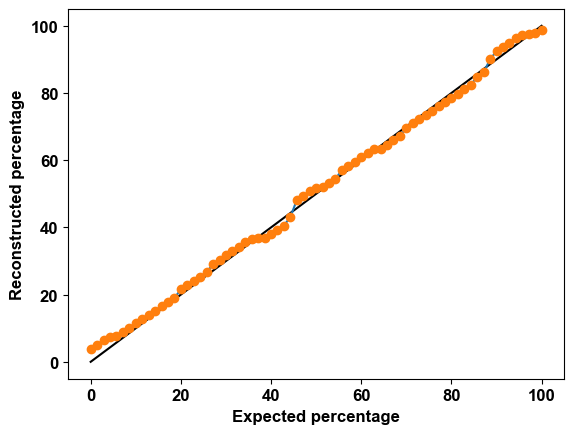

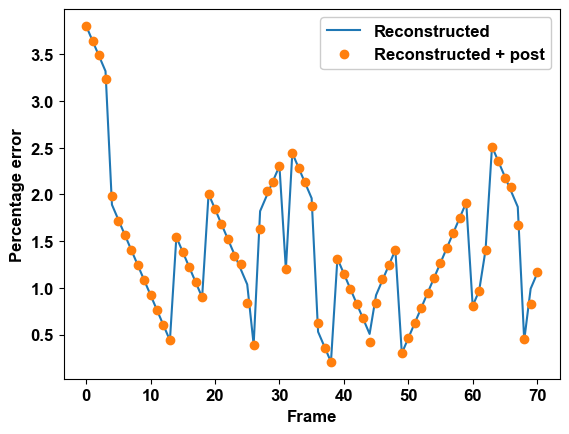

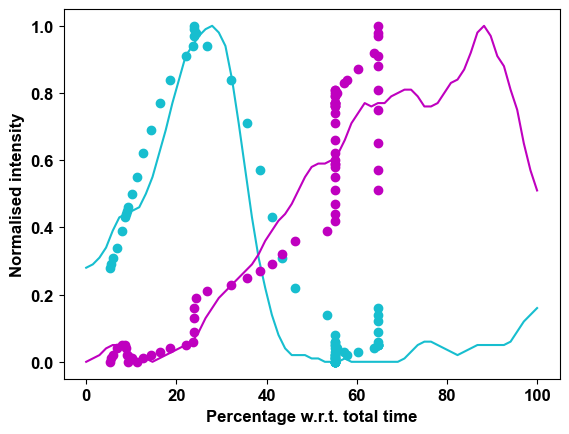

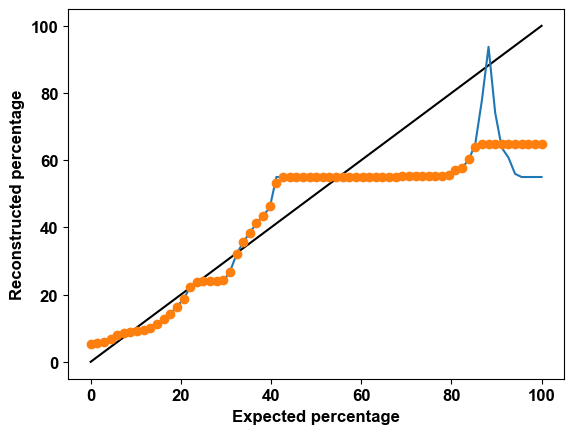

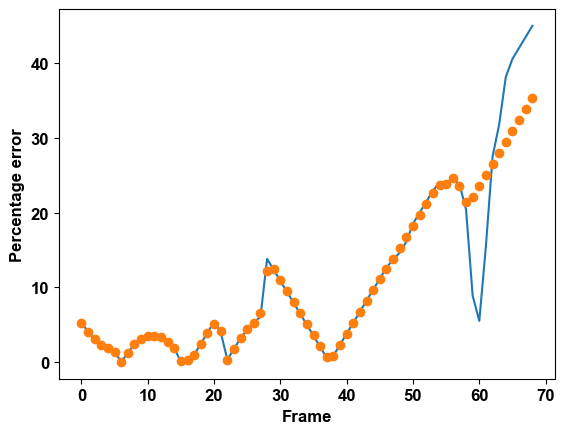

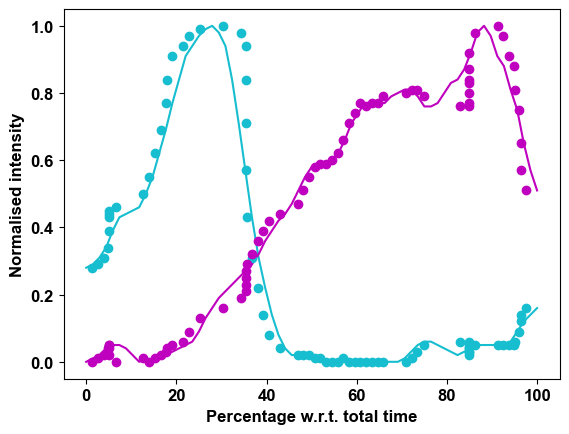

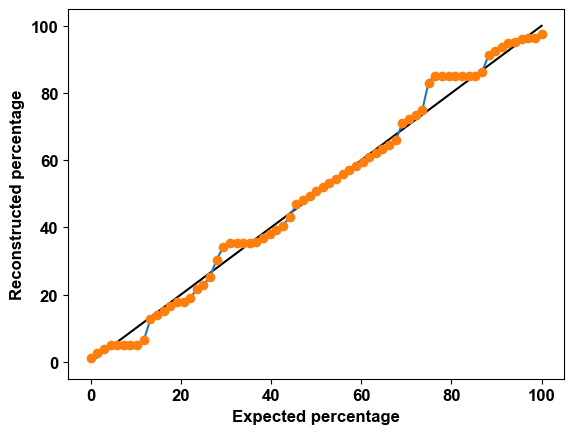

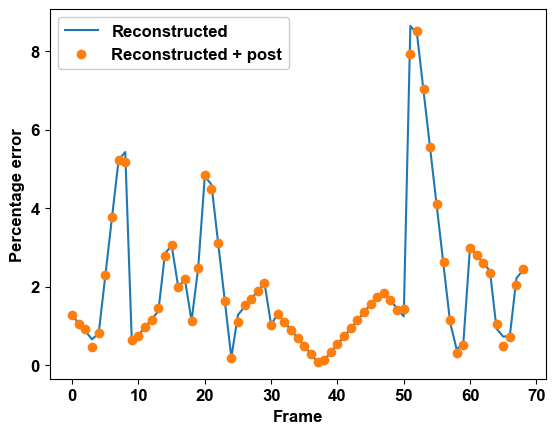

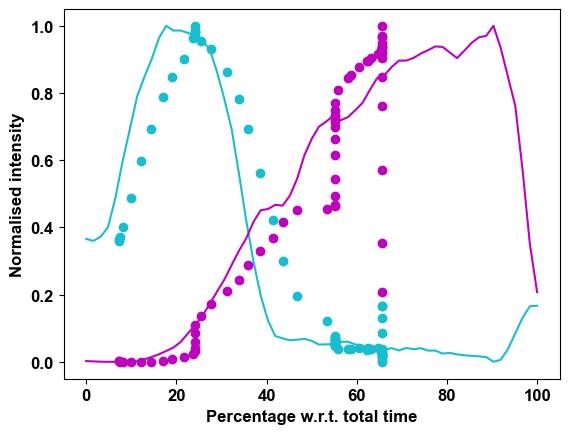

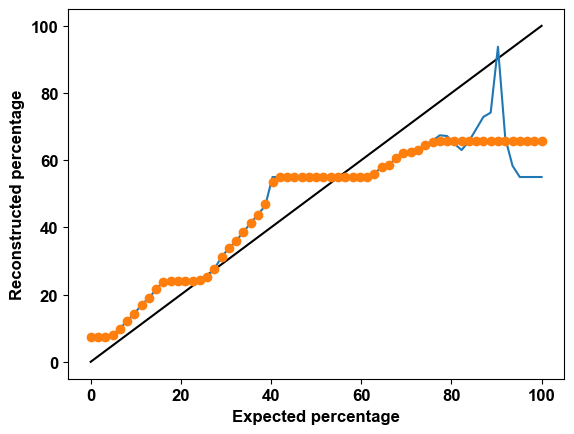

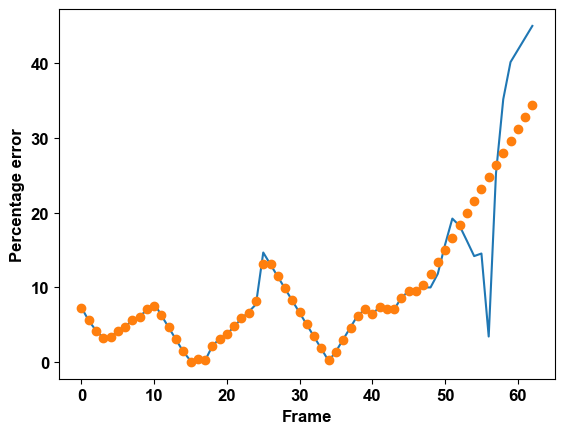

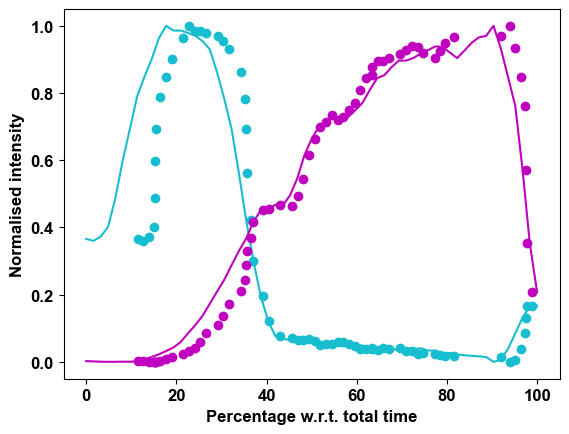

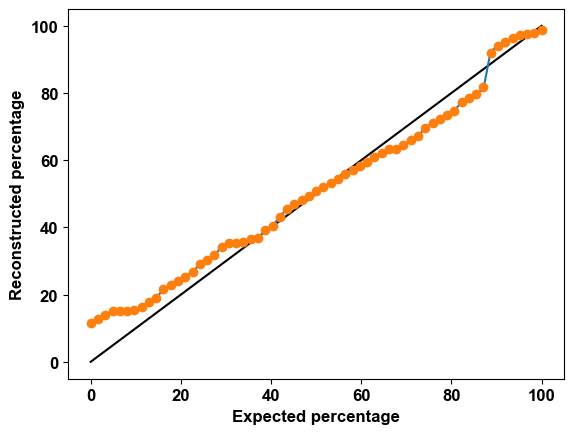

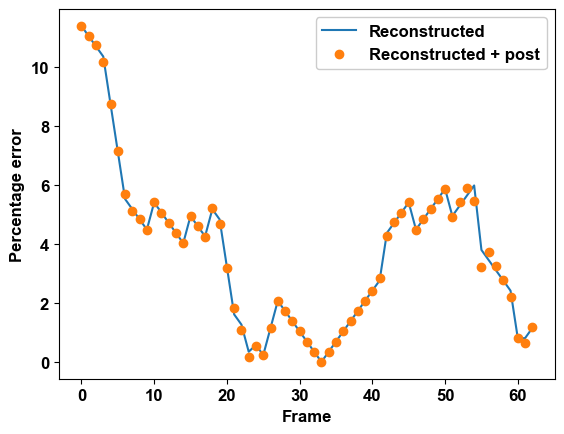

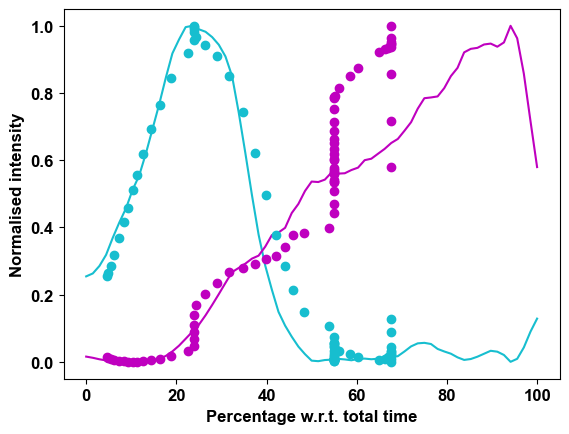

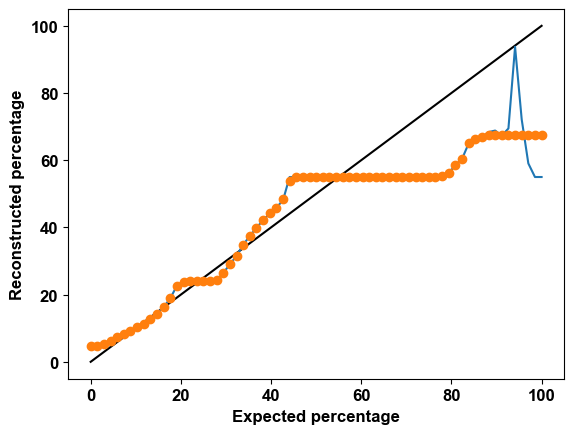

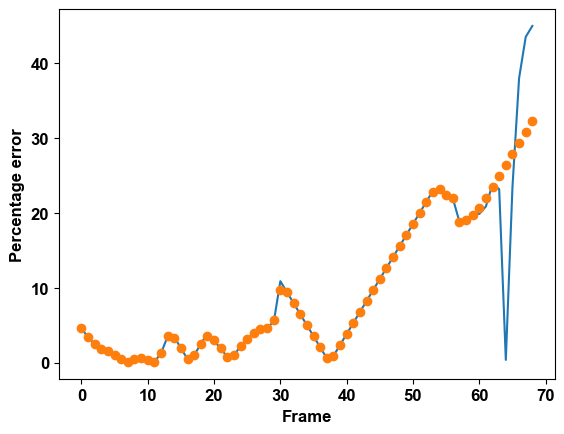

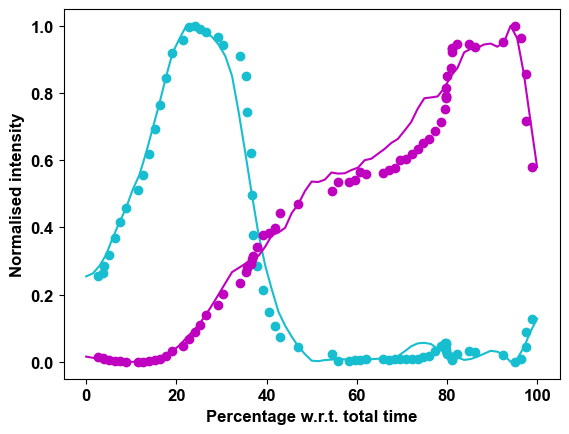

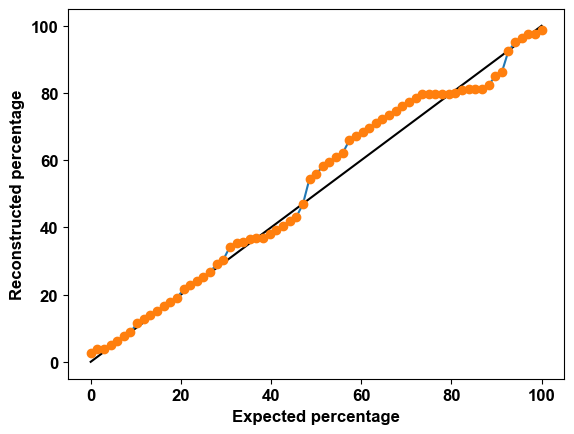

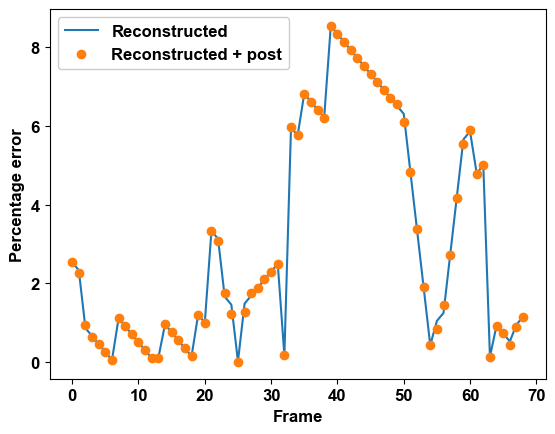

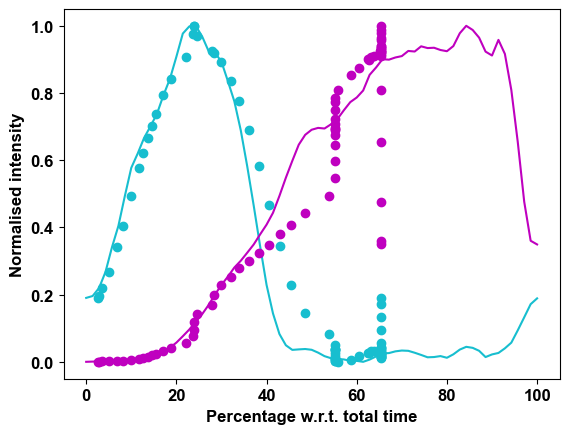

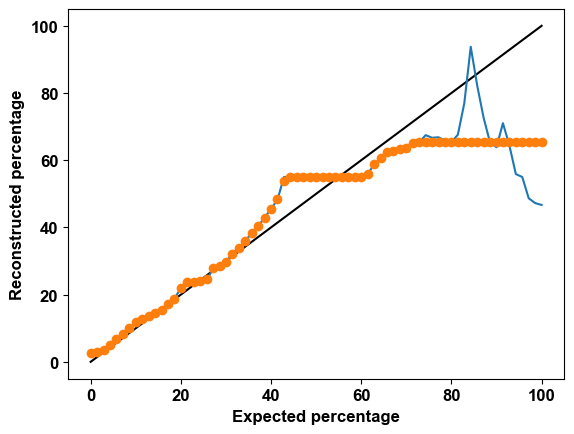

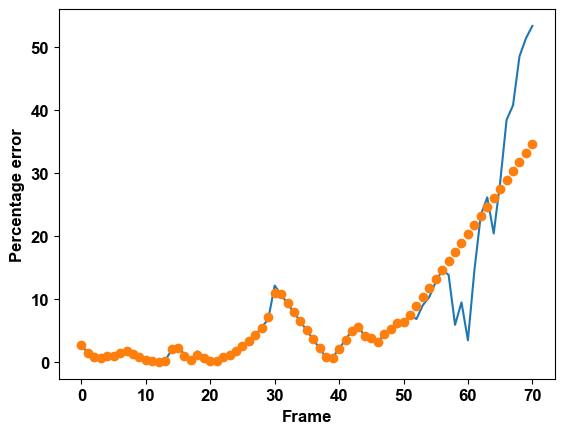

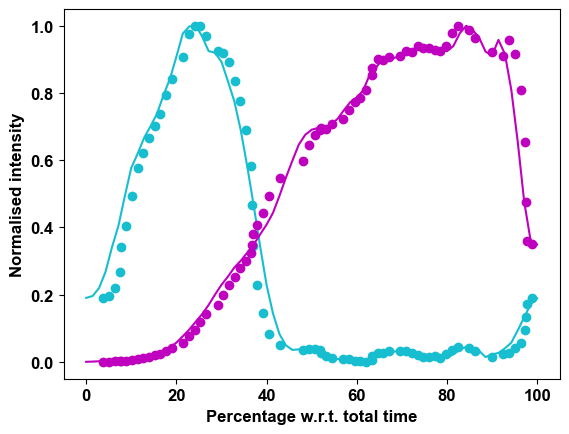

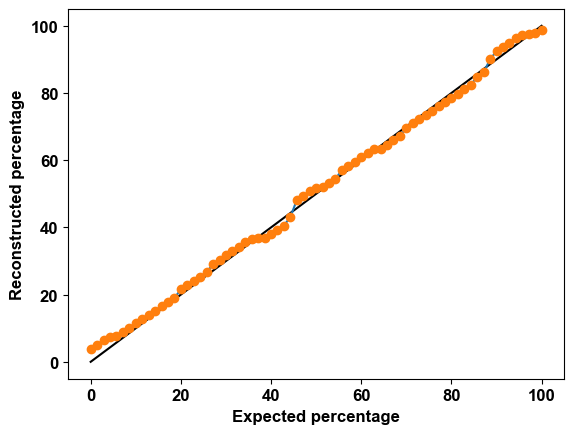

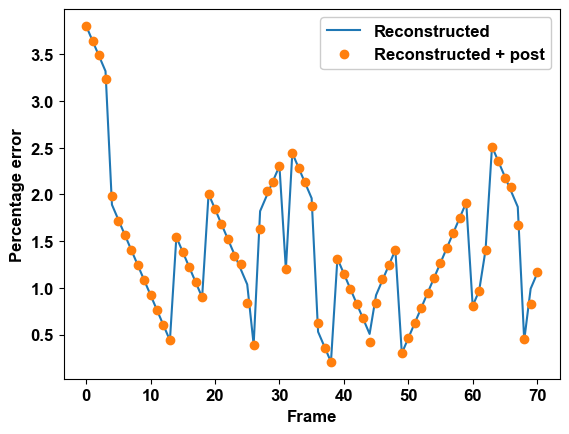

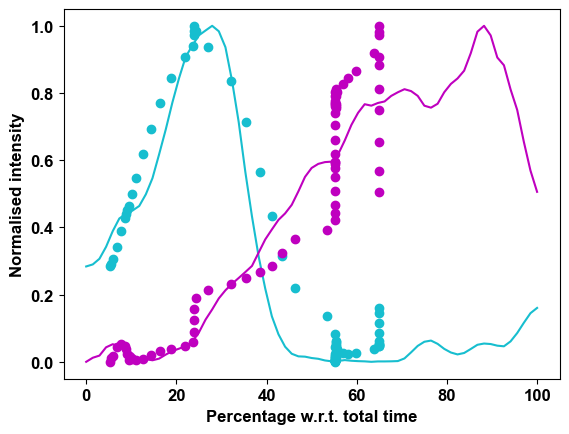

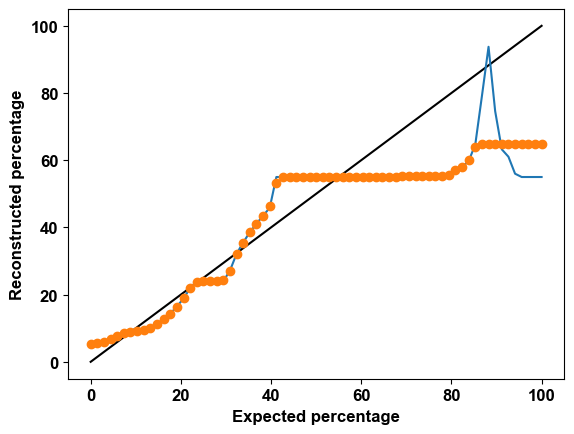

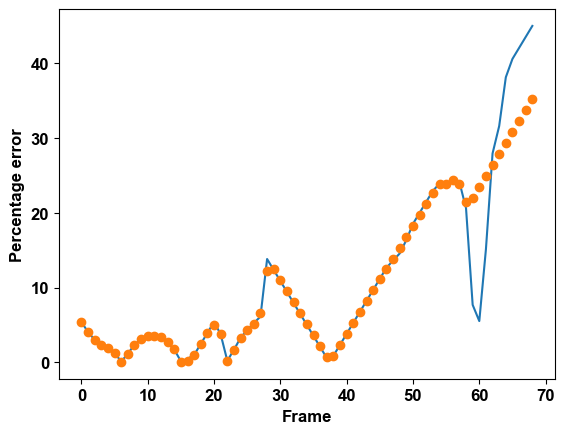

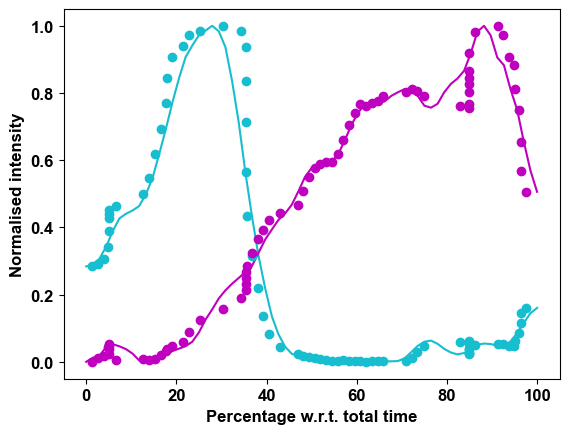

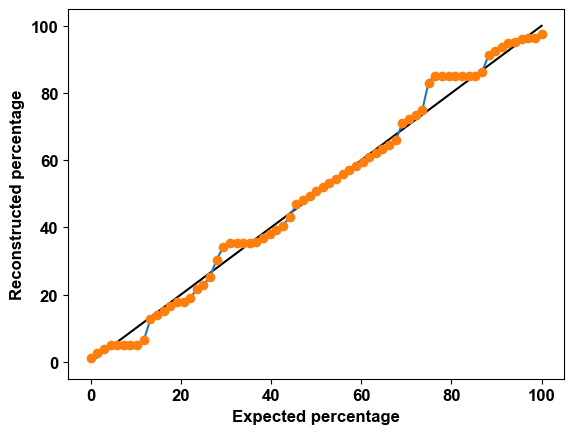

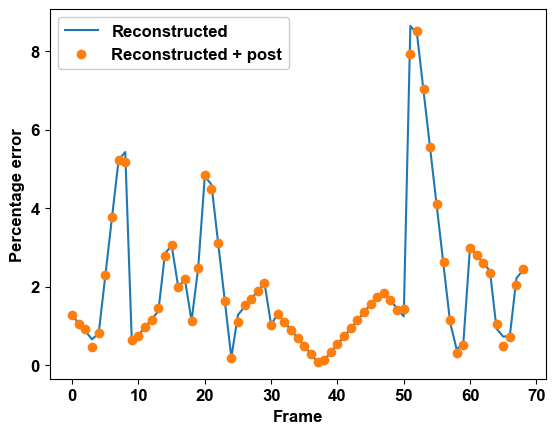

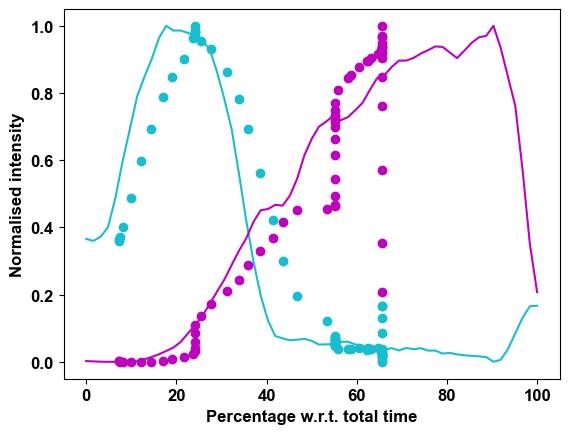

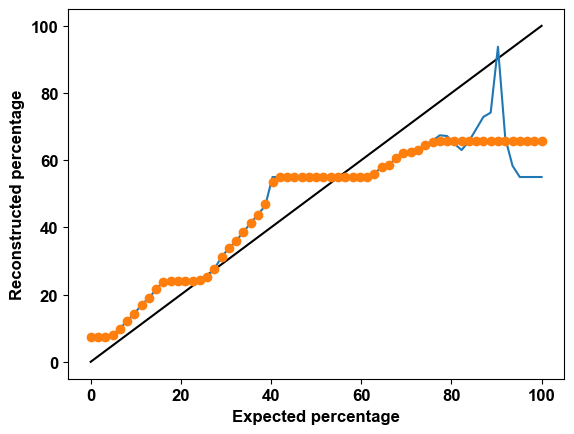

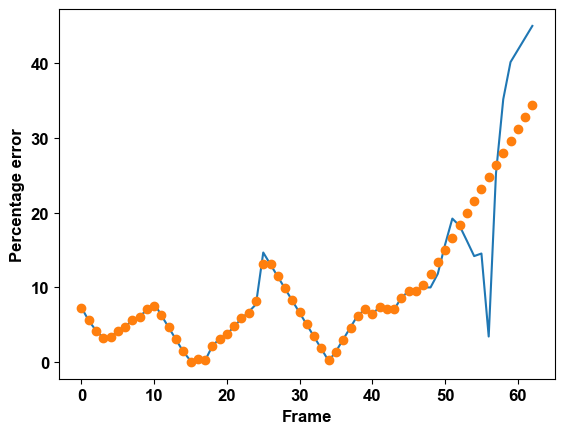

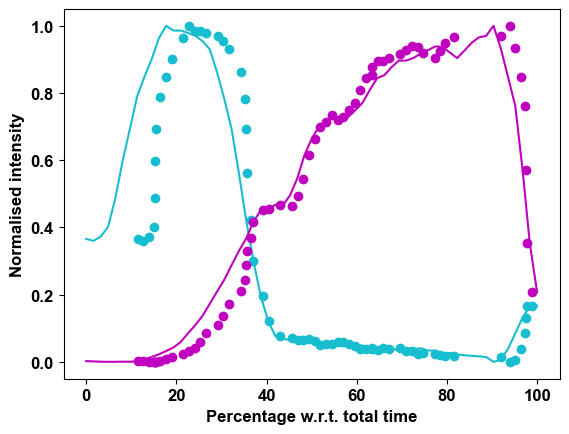

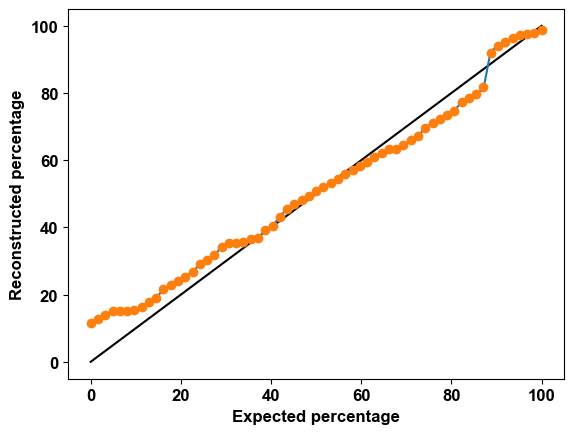

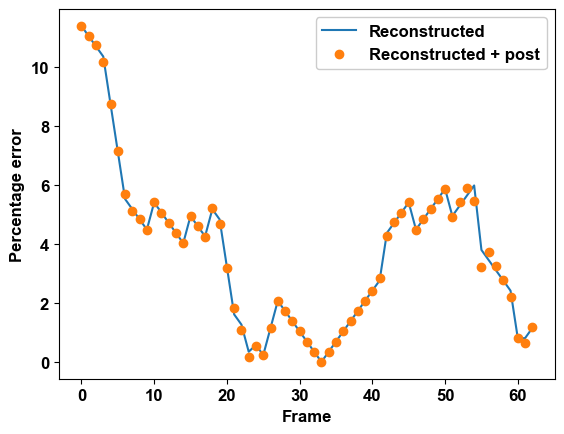

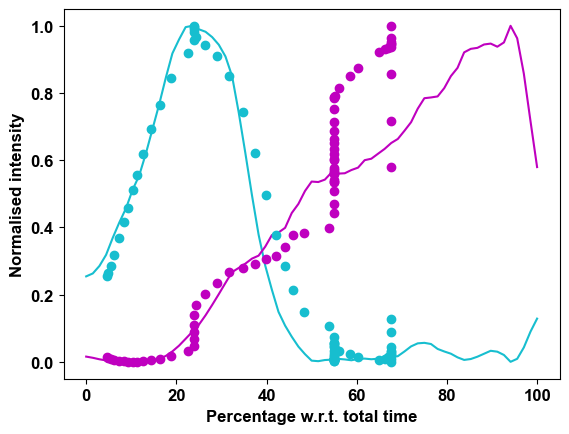

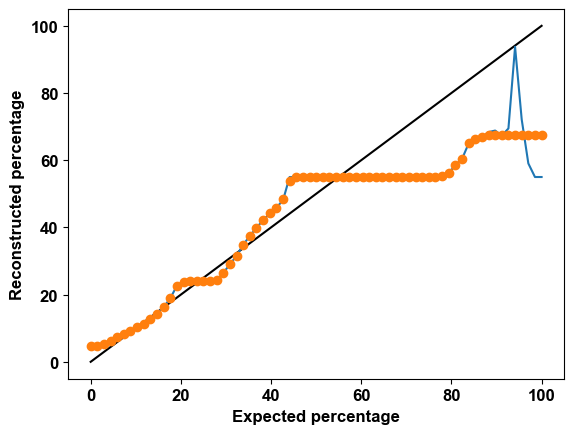

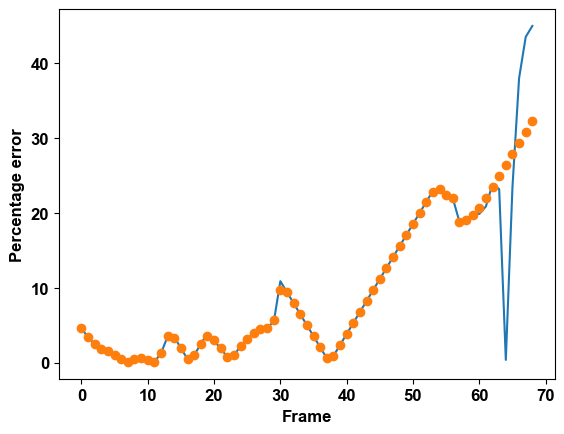

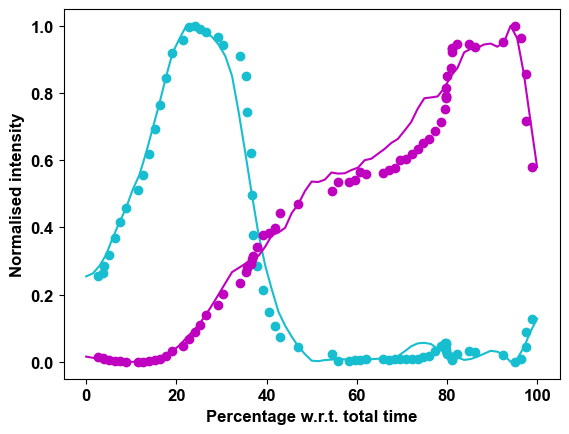

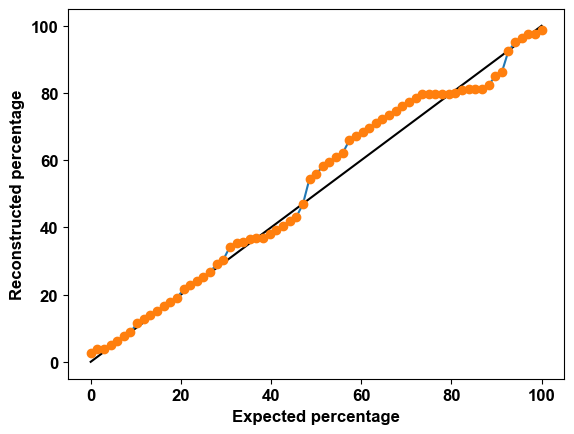

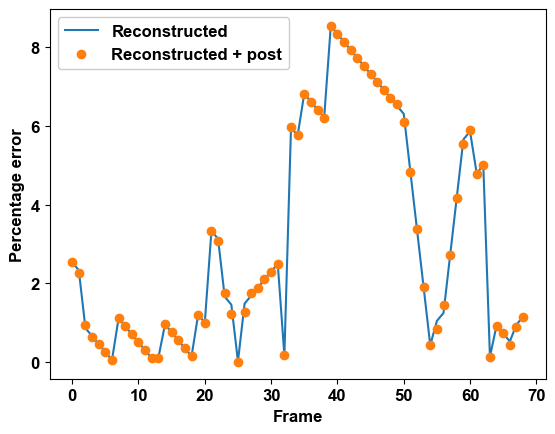

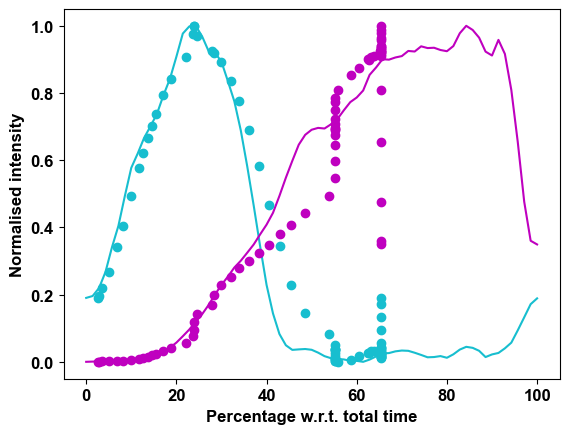

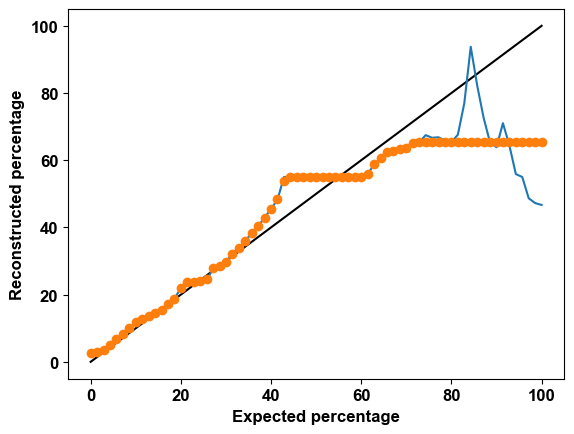

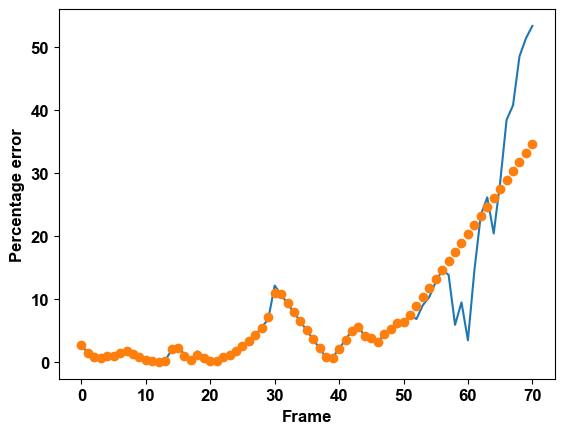

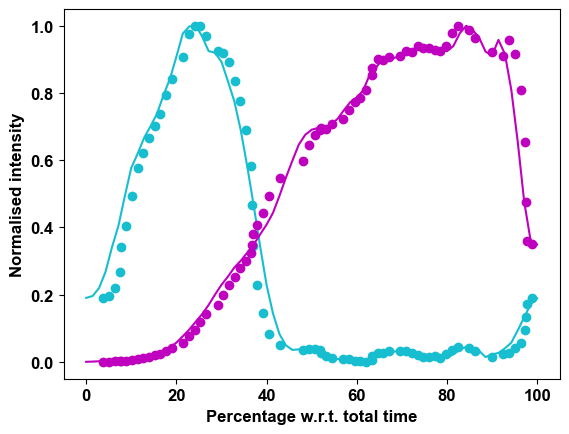

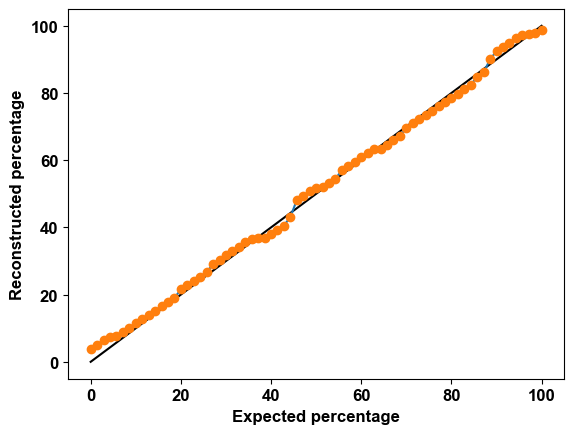

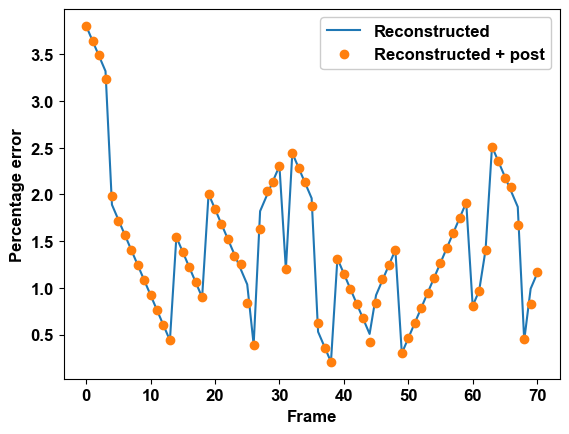

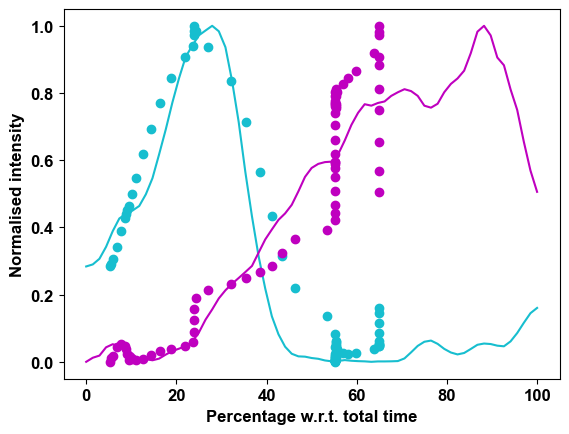

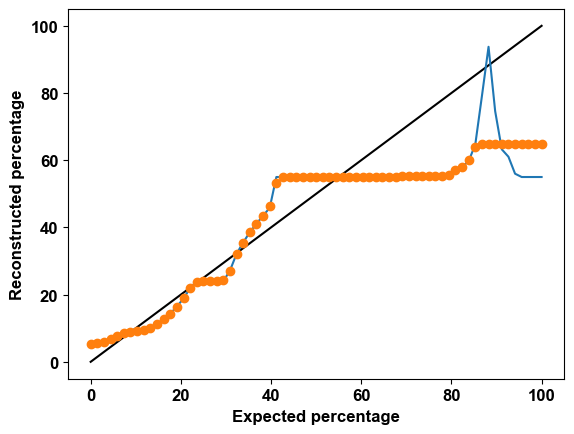

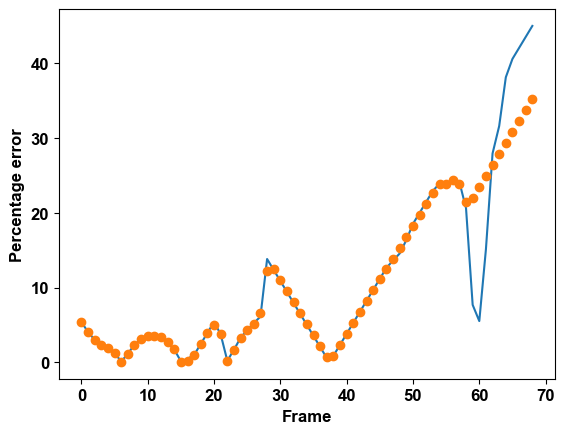

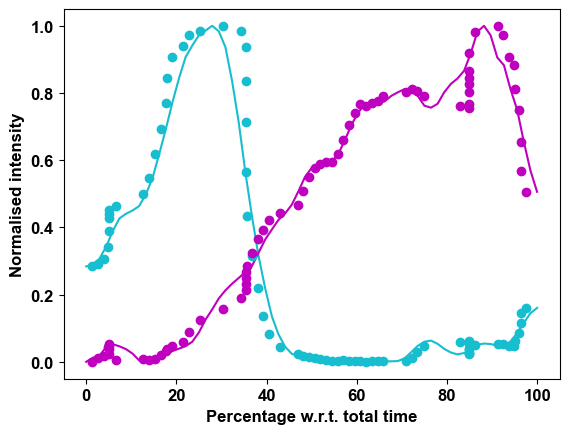

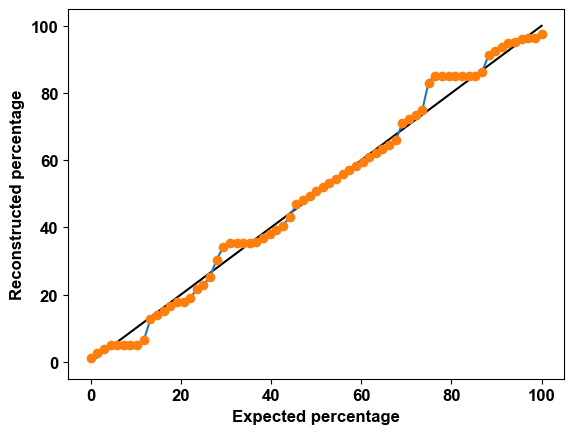

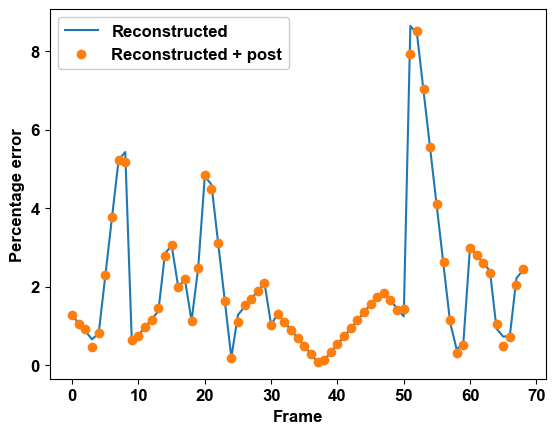

In [38]:
percentage_errors = []

for idx, df in enumerate(dfs_save_tracks):
    normalize_channels(
        df, channels=[cyan_channel, magenta_channel], track_id_name="UNIQUE_TRACK_ID"
    )
    # insert ground truth
    df["percentage"] = (
        100.0
        * (df["FRAME"] - df["FRAME"].min())
        / (df["FRAME"].max() - df["FRAME"].min())
    )
    estimate_cell_cycle_percentage(
        df,
        sensor=sensor,
        channels=[cyan_channel + "_NORM", magenta_channel + "_NORM"],
        phase_column="DISCRETE_PHASE_MAX",
    )
    postprocess_estimated_percentages(
        df, percentage_column="CELL_CYCLE_PERC", track_id_name="UNIQUE_TRACK_ID"
    )

    estimate_percentage_by_subsequence_alignment(
        df,
        dt=0.25,
        channels=[cyan_channel, magenta_channel],
        reference_data=reference_df,
        track_id_name="UNIQUE_TRACK_ID",
    )
    postprocess_estimated_percentages(
        df, percentage_column="CELL_CYCLE_PERC_DTW", track_id_name="UNIQUE_TRACK_ID"
    )

    plot_normalized_intensities(
        df,
        cyan_channel,
        magenta_channel,
        "tab:cyan",
        "m",
        time_column="percentage",
        time_label="Percentage w.r.t. total time",
    )
    plot_normalized_intensities(
        df,
        cyan_channel,
        magenta_channel,
        "tab:cyan",
        "m",
        time_column="CELL_CYCLE_PERC_POST",
        time_label="Percentage w.r.t. total time",
        marker="o",
        linestyle="",
    )
    plt.savefig(f"figures/trackwise_normalization_static_intensities_{idx}.pdf")
    plt.show()

    plt.plot(df["percentage"], df["percentage"], color="black")
    plt.plot(df["percentage"], df["CELL_CYCLE_PERC"])
    plt.plot(df["percentage"], df["CELL_CYCLE_PERC_POST"], "o")
    plt.xlabel("Expected percentage")
    plt.ylabel("Reconstructed percentage")
    plt.savefig(f"figures/trackwise_normalization_static_percentage_{idx}.pdf")
    plt.show()

    plt.plot(
        df["FRAME"] - df["FRAME"].min(),
        np.abs(df["percentage"] - df["CELL_CYCLE_PERC"]),
    )
    plt.plot(
        df["FRAME"] - df["FRAME"].min(),
        np.abs(df["percentage"] - df["CELL_CYCLE_PERC_POST"]),
        "o",
    )
    plt.ylabel("Percentage error")
    plt.xlabel("Frame")
    plt.savefig(f"figures/trackwise_normalization_static_error_{idx}.pdf")

    plt.show()
    plot_normalized_intensities(
        df,
        cyan_channel,
        magenta_channel,
        "tab:cyan",
        "m",
        time_column="percentage",
        time_label="Percentage w.r.t. total time",
    )
    plot_normalized_intensities(
        df,
        cyan_channel,
        magenta_channel,
        "tab:cyan",
        "m",
        time_column="CELL_CYCLE_PERC_DTW_POST",
        time_label="Percentage w.r.t. total time",
        marker="o",
        linestyle="",
    )
    plt.savefig(f"figures/trackwise_normalization_dynamic_intensities_{idx}.pdf")

    plt.show()

    plt.plot(df["percentage"], df["percentage"], color="black")
    plt.plot(df["percentage"], df["CELL_CYCLE_PERC_DTW"])
    plt.plot(df["percentage"], df["CELL_CYCLE_PERC_DTW_POST"], "o")
    plt.xlabel("Expected percentage")
    plt.ylabel("Reconstructed percentage")
    plt.savefig(f"figures/trackwise_normalization_dynamic_percentages_{idx}.pdf")
    plt.show()

    plt.plot(
        df["FRAME"] - df["FRAME"].min(),
        np.abs(df["percentage"] - df["CELL_CYCLE_PERC_DTW"]),
        label="Reconstructed",
    )
    plt.plot(
        df["FRAME"] - df["FRAME"].min(),
        np.abs(df["percentage"] - df["CELL_CYCLE_PERC_DTW_POST"]),
        "o",
        label="Reconstructed + post",
    )
    plt.legend(framealpha=1.0)
    plt.ylabel("Percentage error")
    plt.xlabel("Frame")
    plt.savefig(f"figures/trackwise_normalization_dynamic_error_{idx}.pdf")
    plt.show()

    percentage_errors.append(np.abs(df["percentage"] - df["CELL_CYCLE_PERC_DTW"]))

In [39]:
def run_subsequence_analysis(dfs_save_tracks, subsequence_length, show=False):
    """Analyse impact of subsequence length on accuracy."""
    expected_mean_errors = []
    realized_mean_errors = []

    for idx, df in enumerate(dfs_save_tracks):
        n_windows = len(df) // subsequence_length
        for n in range(n_windows):
            subdf = df.iloc[n * subsequence_length : (n + 1) * subsequence_length]
            estimate_percentage_by_subsequence_alignment(
                subdf,
                dt=0.25,
                channels=[cyan_channel, magenta_channel],
                reference_data=reference_df,
                track_id_name="UNIQUE_TRACK_ID",
                minimum_track_length=0,
            )
            postprocess_estimated_percentages(
                subdf,
                percentage_column="CELL_CYCLE_PERC_DTW",
                track_id_name="UNIQUE_TRACK_ID",
            )

            if show:
                plot_normalized_intensities(
                    subdf,
                    cyan_channel,
                    magenta_channel,
                    "tab:cyan",
                    "m",
                    time_column="percentage",
                    time_label="Percentage w.r.t. total time",
                )
                plot_normalized_intensities(
                    subdf,
                    cyan_channel,
                    magenta_channel,
                    "tab:cyan",
                    "m",
                    time_column="CELL_CYCLE_PERC_DTW_POST",
                    time_label="Percentage w.r.t. total time",
                    marker="o",
                    linestyle="",
                )

                plt.show()

                plt.plot(subdf["percentage"], subdf["percentage"], color="black")
                plt.plot(subdf["percentage"], subdf["CELL_CYCLE_PERC_DTW"])
                plt.plot(subdf["percentage"], subdf["CELL_CYCLE_PERC_DTW_POST"], "o")
                plt.xlabel("Expected percentage")
                plt.ylabel("Reconstructed percentage")
                plt.show()

                plt.plot(
                    subdf["FRAME"] - subdf["FRAME"].min(),
                    np.abs(subdf["percentage"] - subdf["CELL_CYCLE_PERC_DTW"]),
                )
                plt.plot(
                    subdf["FRAME"] - subdf["FRAME"].min(),
                    np.abs(subdf["percentage"] - subdf["CELL_CYCLE_PERC_DTW_POST"]),
                    "o",
                )
                plt.plot(
                    subdf["FRAME"] - subdf["FRAME"].min(),
                    percentage_errors[idx][
                        n * subsequence_length : (n + 1) * subsequence_length
                    ],
                    label="Full sequence",
                )
                plt.legend(framealpha=1.0)
                plt.ylabel("Percentage error")
                plt.xlabel("Frame")
                plt.show()

            expected_mean_errors.append(
                np.mean(
                    percentage_errors[idx][
                        n * subsequence_length : (n + 1) * subsequence_length
                    ]
                )
            )
            realized_mean_errors.append(
                np.mean(np.abs(subdf["percentage"] - subdf["CELL_CYCLE_PERC_DTW_POST"]))
            )

    if show:
        plt.plot(expected_mean_errors, label="Expected")
        plt.plot(realized_mean_errors, label="Realized")
        plt.show()
    print(
        f"Expected: {np.mean(expected_mean_errors)} +- {np.std(expected_mean_errors)}"
    )
    print(
        f"Realized: {np.mean(realized_mean_errors)} +- {np.std(realized_mean_errors)}"
    )
    return expected_mean_errors, realized_mean_errors

In [40]:
expected_error = {}
realized_error = {}
for subsequence_length in [5, 10, 20, 30]:
    exp, real = run_subsequence_analysis(
        dfs_candidate_tracks, subsequence_length=subsequence_length
    )
    expected_error[subsequence_length] = exp
    realized_error[subsequence_length] = real

Expected: nan +- nan
Realized: nan +- nan
Expected: nan +- nan
Realized: nan +- nan
Expected: nan +- nan
Realized: nan +- nan
Expected: nan +- nan
Realized: nan +- nan


C:\Users\SPL_ImageAnalysis-WS\anaconda3\envs\fucciphase_run\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\SPL_ImageAnalysis-WS\anaconda3\envs\fucciphase_run\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\SPL_ImageAnalysis-WS\anaconda3\envs\fucciphase_run\lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\SPL_ImageAnalysis-WS\anaconda3\envs\fucciphase_run\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\SPL_ImageAnalysis-WS\anaconda3\envs\fucciphase_run\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret =

C:\Users\SPL_ImageAnalysis-WS\AppData\Local\Temp\ipykernel_24244\1351250080.py:15: RuntimeWarning: Mean of empty slice
  np.nanmean(expected_mean_errors),
C:\Users\SPL_ImageAnalysis-WS\anaconda3\envs\fucciphase_run\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


5
10
20
30


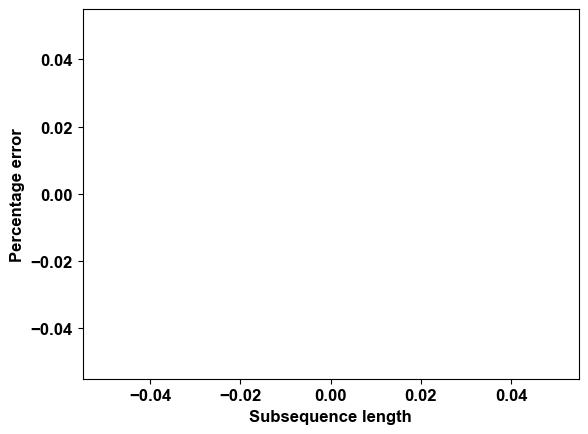

In [41]:
for subsequence_length in expected_error:
    print(subsequence_length)
    expected_mean_errors = expected_error[subsequence_length]
    realized_mean_errors = realized_error[subsequence_length]
    plt.errorbar(
        subsequence_length,
        np.mean(realized_mean_errors),
        np.std(realized_mean_errors),
        fmt="v",
        capsize=5,
        color="blue",
    )
    plt.errorbar(
        subsequence_length,
        np.nanmean(expected_mean_errors),
        np.nanstd(expected_mean_errors),
        fmt="o",
        capsize=5,
        color="orange",
    )
plt.ylabel("Percentage error")
plt.xlabel("Subsequence length")
plt.savefig("error_subsequence.svg")
plt.show()